# **CP3 2023**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from utils_public import *

#### **Introduction**

**Topology Optimization**
Structural topology optimization typically aims to find the optimal material layout to maximize mechanical performance. Minimizing compliance given a limited material budget is a classic formulation for a class of topology optimization problems, though other objectives such as heat dissipation are also common. Often, the limited material (specified as a volume fraction) is placed to optimally withstand a given force (or forces), while relying on a given set of boundary conditions for support, as shown below.


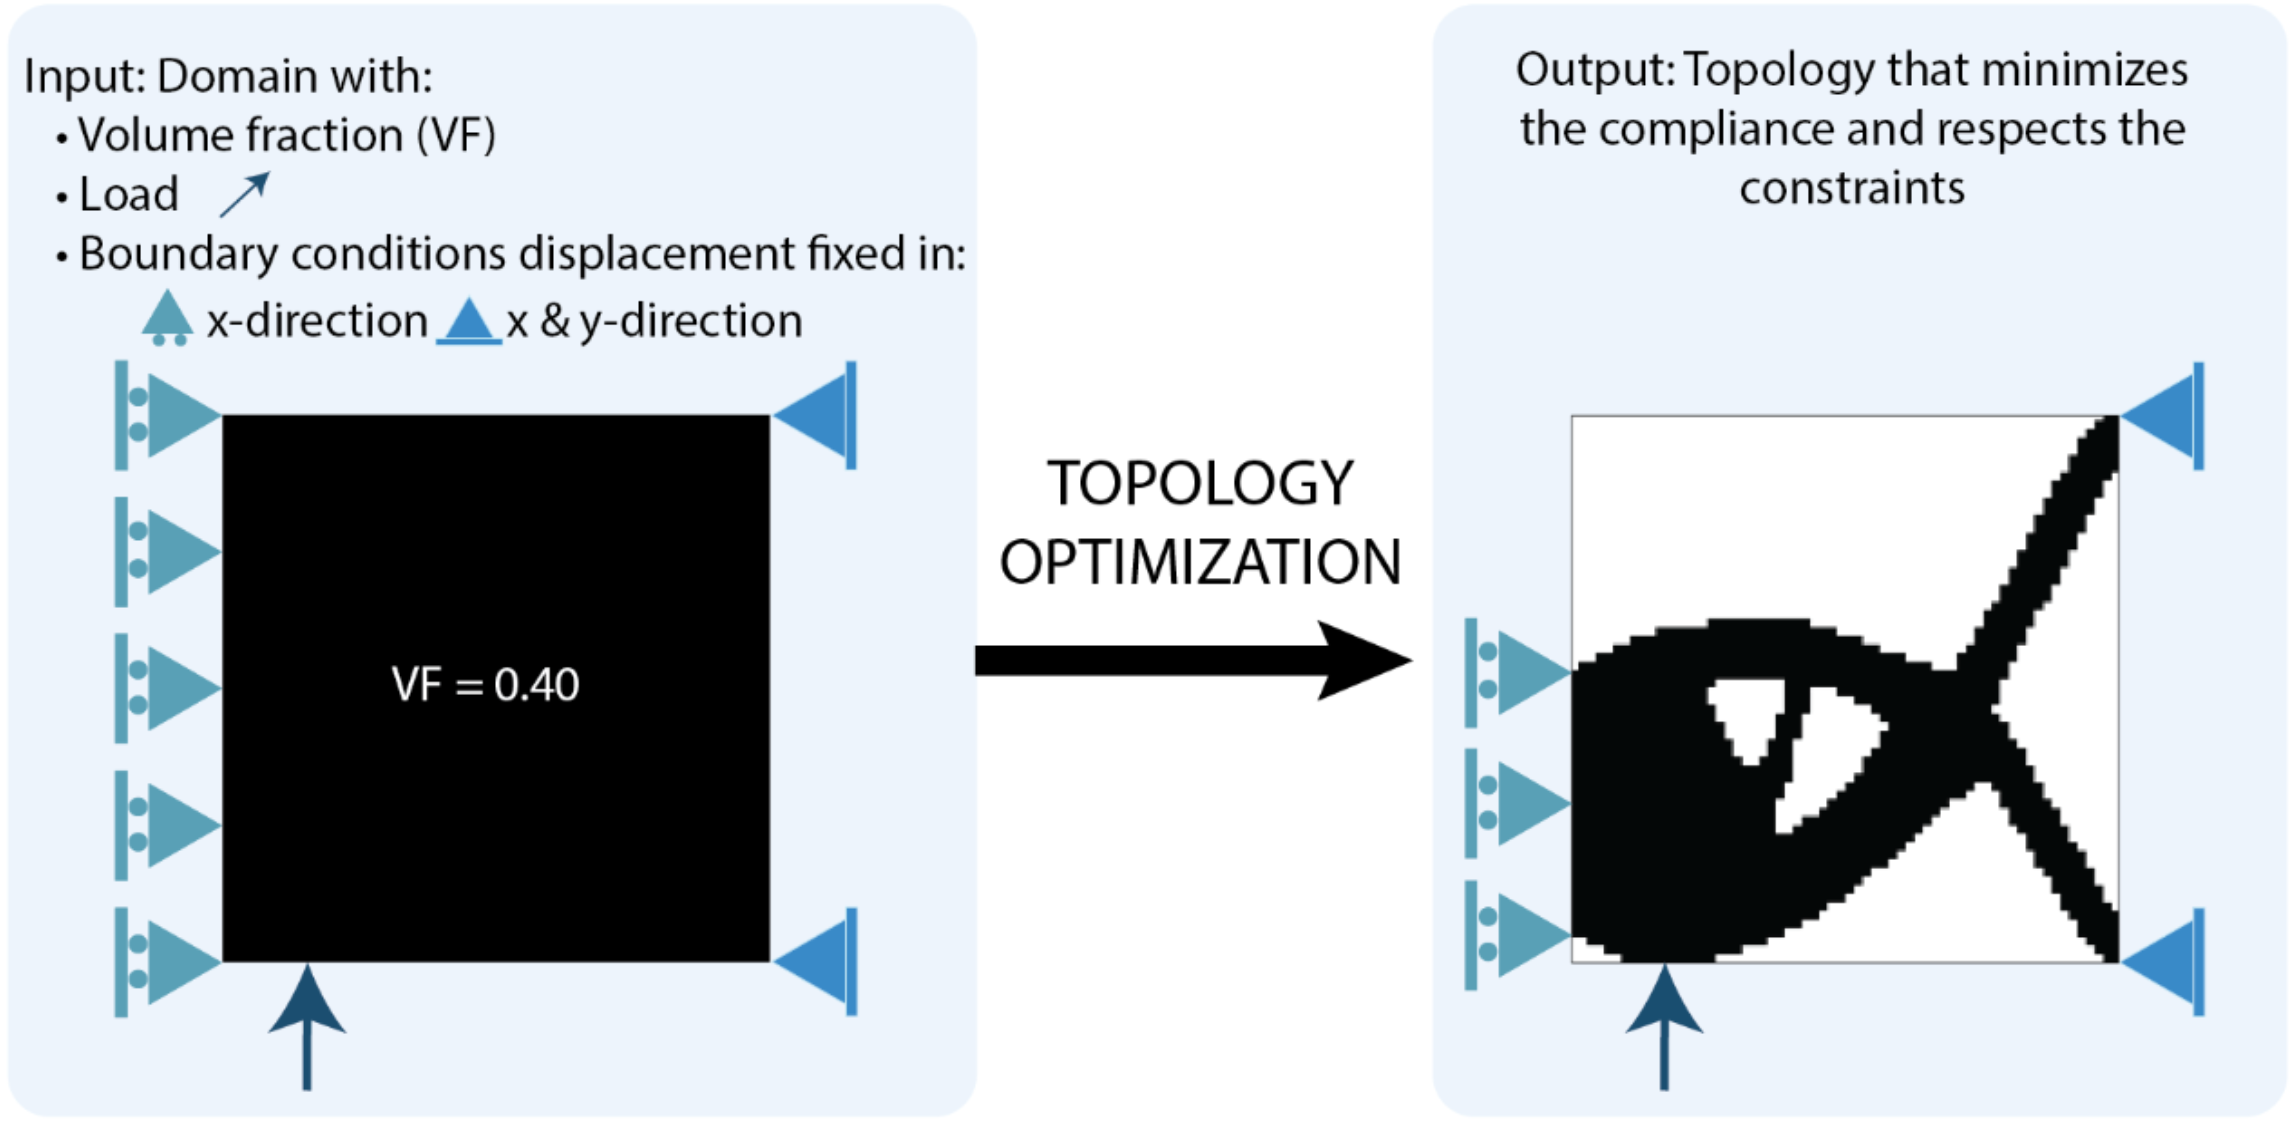

source: "Diffusion Models Beat GANs on Topology Optimization," Maze & Ahmed, 2023

### **The Task**
In this challenge problem, we task you with reconstructing corrupted topologies for which portions of the structure have been deleted, as shown below.

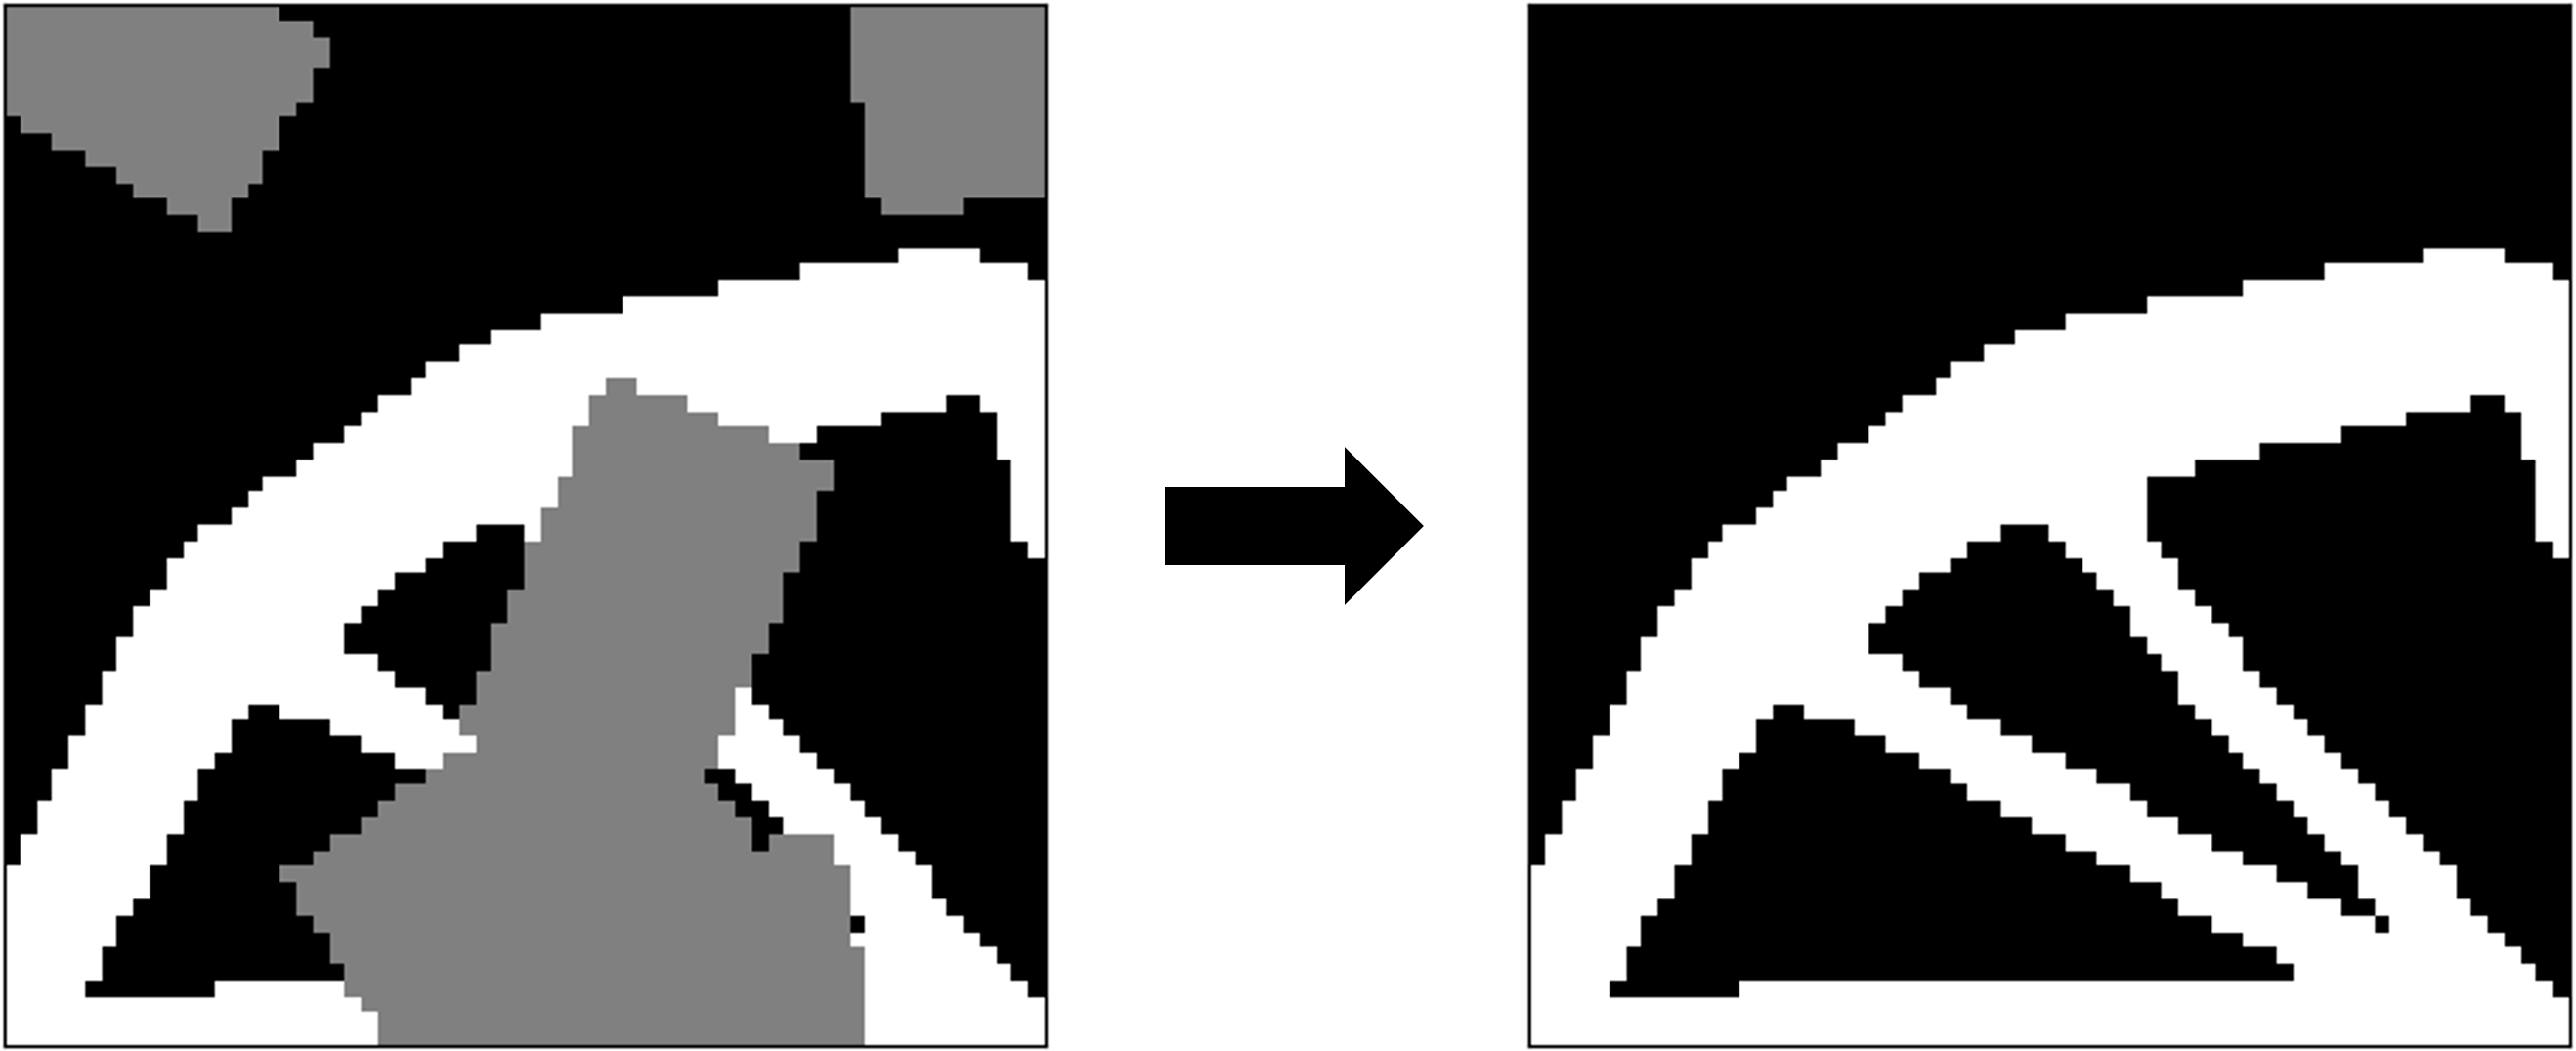


For the sake of this challenge problem, we will pretend that a malicious hacker has corrupted part of your dataset and you are trying to restore the data to its previous state as faithfully as possible. However, as discussed in lecture, reconstructing masked portions of a dataset has powerful practical purposes. For example, it can be a potent method to train self-supervised learners. Masking is often used for inpainting tasks, and can be an viable method for human-AI collaboration (Say, if you wanted to remake a portion of a topology based on a new constraint constraint or even an aesthetic preference).

**The Dataset:**

We provide a dataset of 12,000 (uncorrupted) 64x64 topologies optimized for compliance minimization under a variety of loads, support cases, and material budgets. In these problems, 5 types of conditioning information are given, over which the material placement has been optimized. We'll refer to these simply as the 'constraints.'


*   Horizontal boundary conditions
*   Vertical boundary conditions
*   Horizontal loads
*   Vertical loads
*   Volume fraction



Let's first load the topologies and check their shape:

In [3]:
topologies = np.load("topologies_train.npy")
print(topologies.shape)

(12000, 64, 64)


Let's plot some of the topologies from the dataset:

<Figure size 640x480 with 0 Axes>

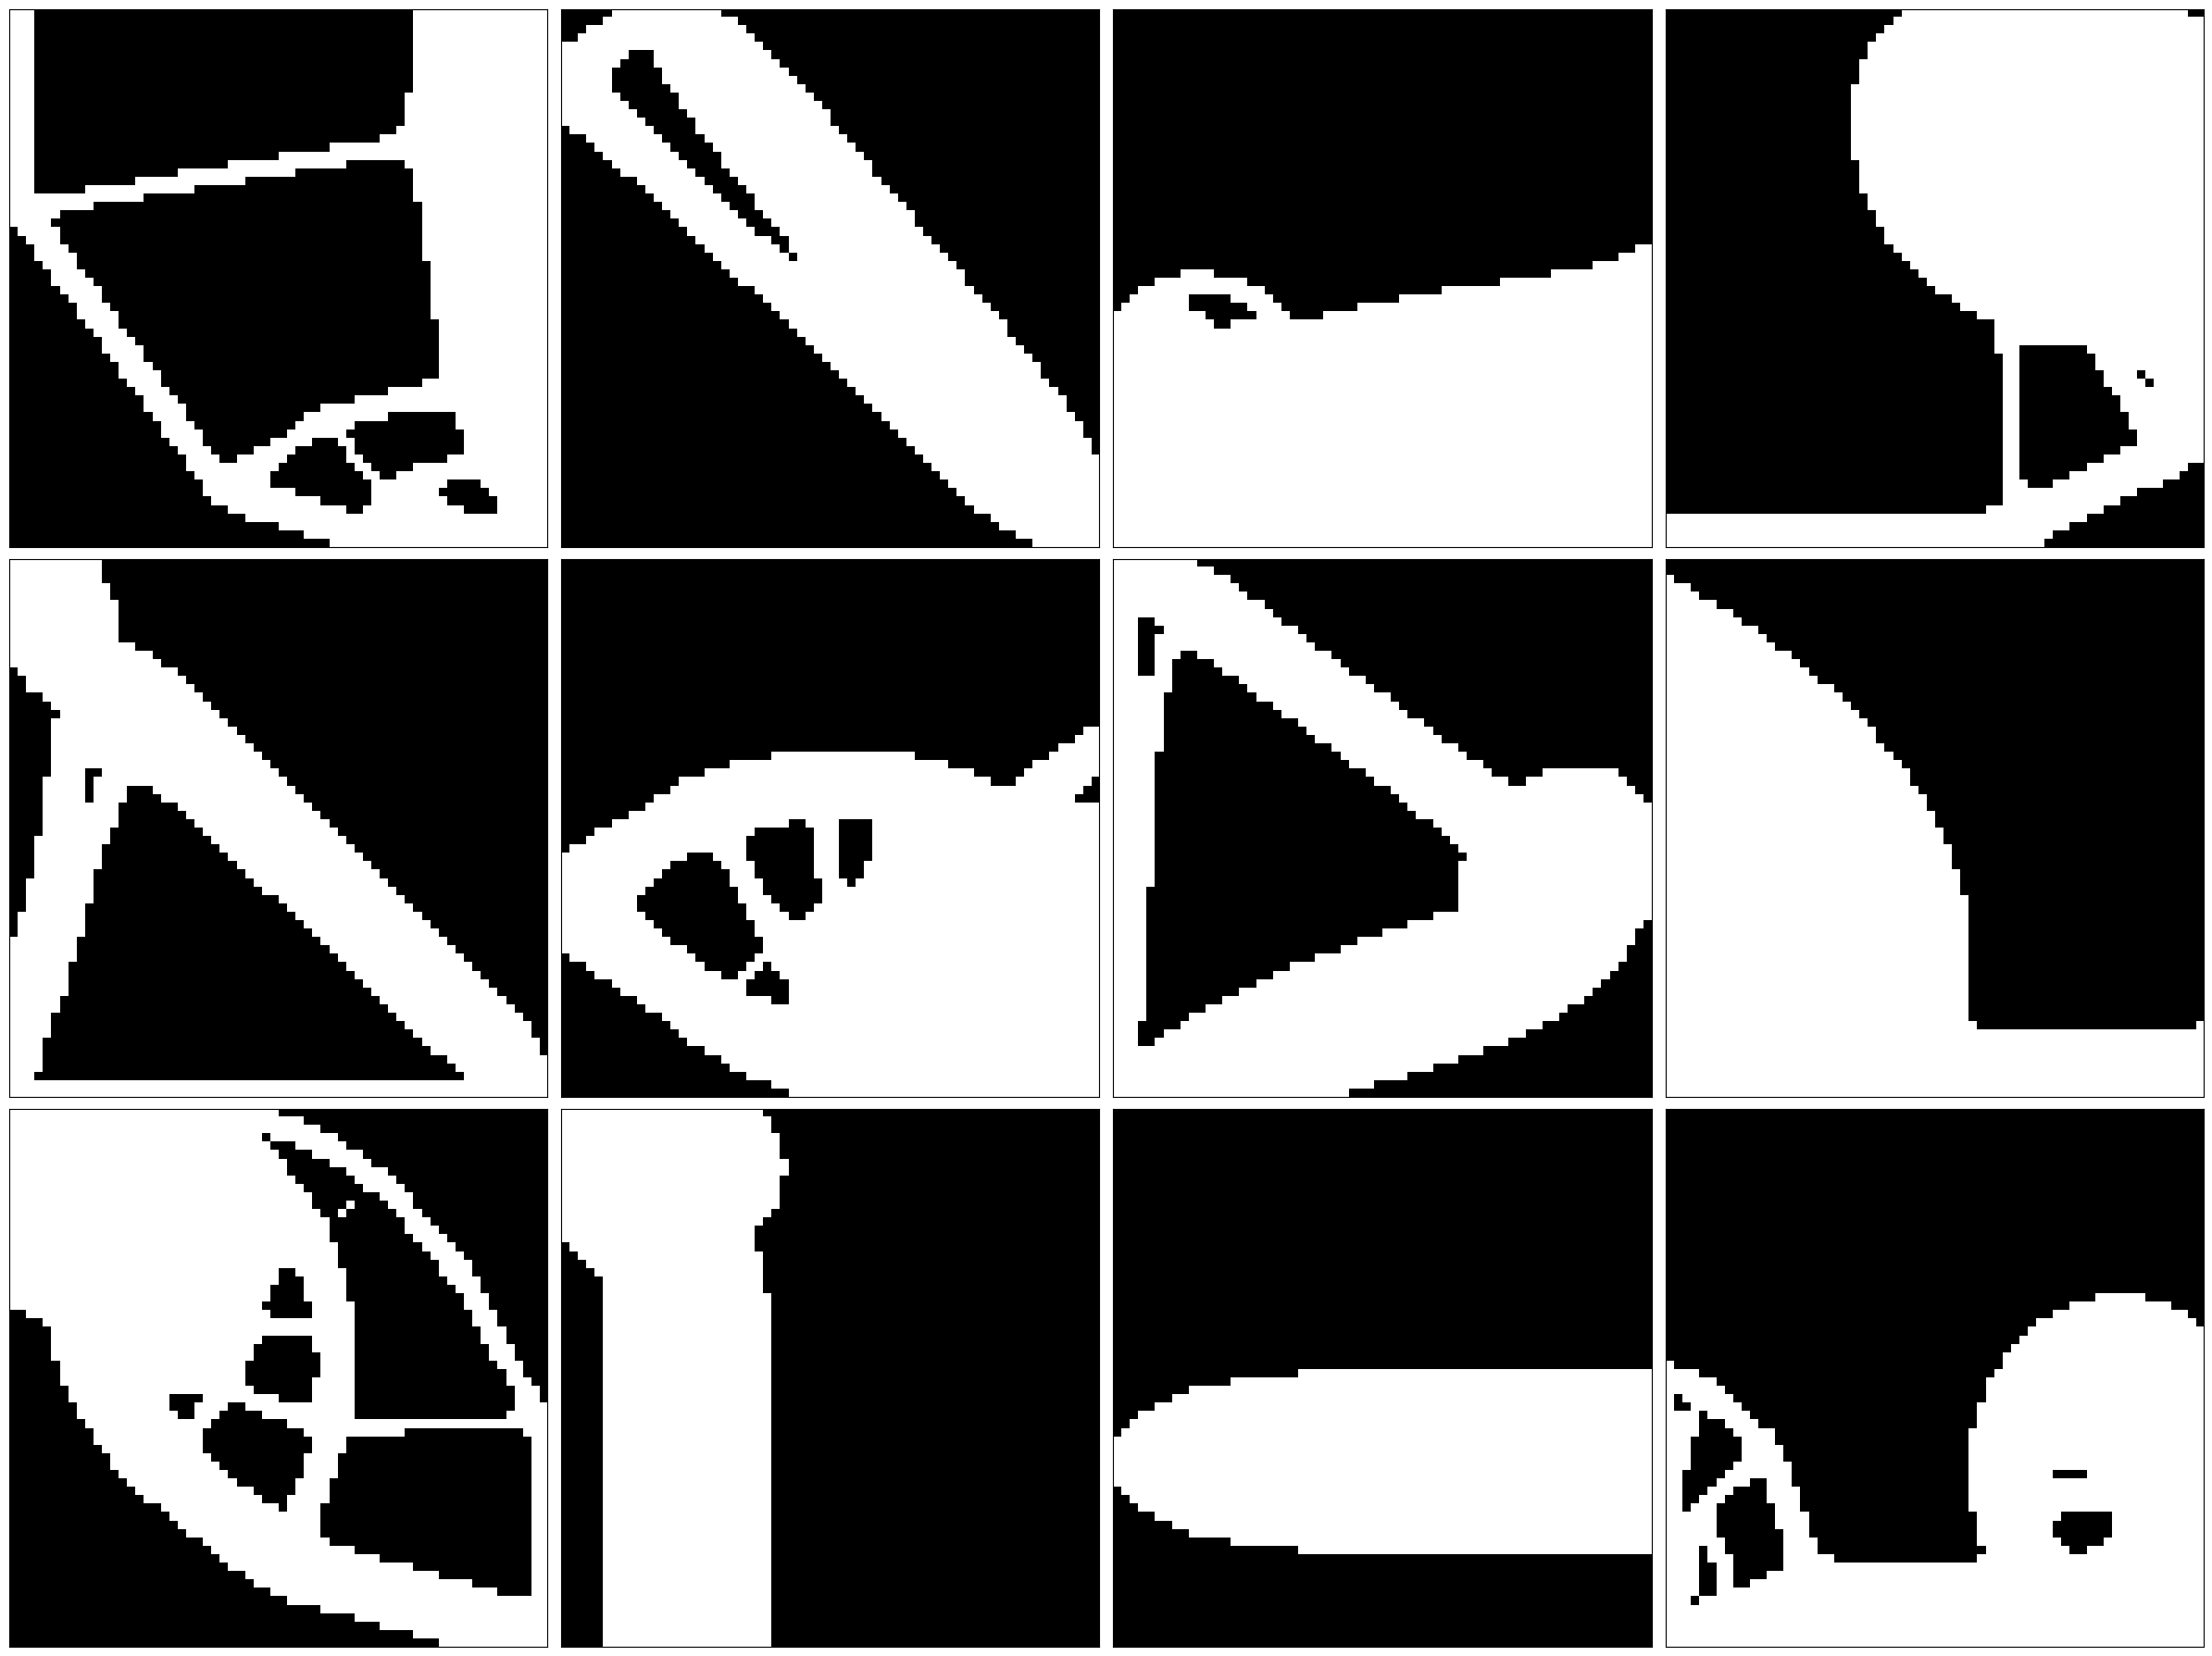

In [3]:
random_indices = np.random.choice(range(len(topologies)), 12)
plot_n_topologies(topologies[random_indices])

Now lets take a look at the constraints that was used to generate these topologies.

In [4]:
constraints = np.load("constraints_train.npy", allow_pickle=True)
print(len(constraints))
constraints[0]

12000


array([<64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 68 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 70 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 1 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 1 stored elements in Compressed Sparse Row format>,
       0.46000000000000013], dtype=object)

The constraints are given as a list of numpy arrays (in the same order as the topologies). The arrays each have five elements:

*   Horizontal boundary conditions (2D sparse matrix)
*   Vertical boundary conditions (2D sparse matrix)
*   Horizontal loads (2D sparse matrix)
*   Vertical loads (2D sparse matrix)
*   Volume fraction (float)

Let's take a look at the horizontal boundary conditions for the first topology in the dataset


In [5]:
print(constraints[0][0])

  (0, 0)	1.0
  (0, 63)	1.0
  (1, 0)	1.0
  (1, 63)	1.0
  (2, 63)	1.0
  (3, 63)	1.0
  (4, 63)	1.0
  (5, 63)	1.0
  (6, 63)	1.0
  (7, 63)	1.0
  (8, 63)	1.0
  (9, 63)	1.0
  (10, 63)	1.0
  (11, 63)	1.0
  (12, 63)	1.0
  (13, 63)	1.0
  (14, 63)	1.0
  (15, 63)	1.0
  (16, 63)	1.0
  (17, 63)	1.0
  (18, 63)	1.0
  (19, 63)	1.0
  (20, 63)	1.0
  (21, 63)	1.0
  (22, 63)	1.0
  :	:
  (41, 63)	1.0
  (42, 63)	1.0
  (43, 63)	1.0
  (44, 63)	1.0
  (45, 63)	1.0
  (46, 63)	1.0
  (47, 63)	1.0
  (48, 63)	1.0
  (49, 63)	1.0
  (50, 63)	1.0
  (51, 63)	1.0
  (52, 63)	1.0
  (53, 63)	1.0
  (54, 63)	1.0
  (55, 63)	1.0
  (56, 63)	1.0
  (57, 63)	1.0
  (58, 63)	1.0
  (59, 63)	1.0
  (60, 63)	1.0
  (61, 63)	1.0
  (62, 0)	1.0
  (62, 63)	1.0
  (63, 0)	1.0
  (63, 63)	1.0


We can convert these sparse matrices to numpy arrays. Let's do so and visualize.

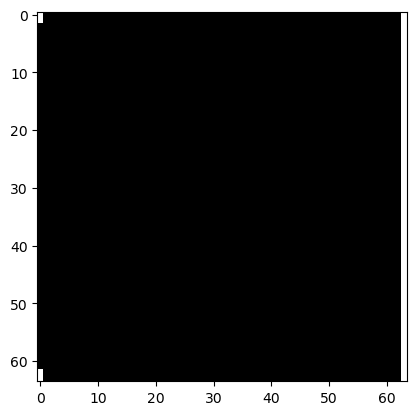

In [6]:
plt.imshow(constraints[0][0].toarray(), cmap="gray")

**Masking Functions:**

As discussed, we will be asking you to reconstruct topologies that have been partially masked. We have provided the EXACT masking function that we have used to generate the test set and the submission set. Note that this function is randomized. Let's take a look at some random masks and apply them to the sample topologies shown above.

In [5]:
masked_topologies = []
for i in trange(len(topologies)):
    mask = random_n_masks(np.array((64,64)), 4, 7).astype(bool) #From the utils file - feel free to check it out
    topology = topologies[i]
    masked_topology = topology*(1-mask) + 0.5*(mask)
    masked_topologies.append(masked_topology)
masked_topologies = np.stack(masked_topologies)


  0%|          | 5/12000 [00:00<04:46, 41.81it/s]

100%|██████████| 12000/12000 [02:50<00:00, 70.53it/s]


New, let's take a look at what these topologies look like after we have applied a mask. The masked areas are shown in gray:

<Figure size 640x480 with 0 Axes>

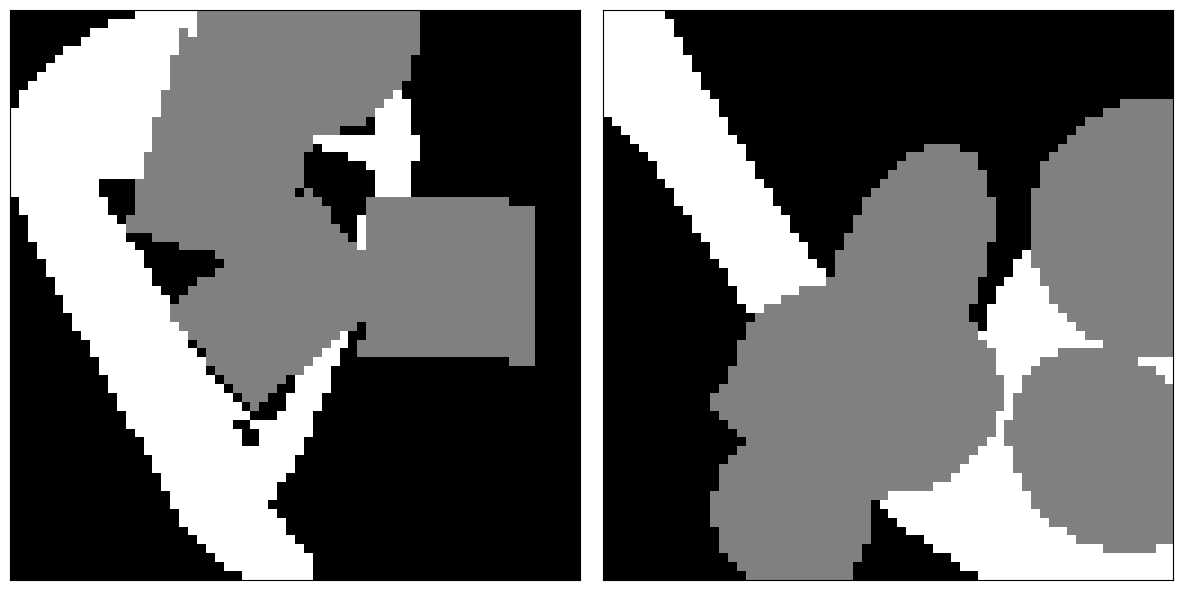

(12000, 64, 64)


In [133]:
plot_n_topologies(masked_topologies[random_indices])


In [136]:
print(masked_topologies.shape)

(12000, 64, 64)


Constraints also get masked. For each topology, two of the five types of constraints (e.g. horizontal loads) will be converted to a Nonetype. Note: We do not base any scoring on reconstruction of masked constraints. However, doing so can help reconstruct topologies, which are scored.

Let's take a look at the constraint masking function:

In [6]:
masked_constraints = mask_constraints(constraints) #From the utils file
print(masked_constraints[0])

[<64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 68 stored elements in Compressed Sparse Row format>
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 70 stored elements in Compressed Sparse Row format>
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format> None None]


### **Starter Code: VAE**
We have provided you some starter code in which we attempt to reconstruct the original topologies using a Variational Autoencoder (VAE). Below, we define the VAE model and a train loop function.

Note: This code does NOT make use of constraints.

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class VAE(nn.Module): #Create VAE class inheriting from pytorch nn Module class
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(VAE, self).__init__()

        # Create encoder model
        self.encoder = Encoder(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride)

        #Create decoder after calculating input size for decoder
        decoder_input_size = self.calculate_decoder_input_size(image_size, num_layers, kernel_size, stride)
        self.decoder = Decoder(input_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size)

    def calculate_decoder_input_size(self, image_size, num_layers, kernel_size, stride):
        #Function to calculate the input size of the decoder given its architecture
        h, w = image_size
        for _ in range(num_layers):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h, w

    def reparameterize(self, mu, logvar):
        #Sample from gaussian
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_in):
        #Pass through encoder, reparameterize using mu and logvar as given by the encoder, then pass through decoder
        mu, logvar = self.encoder(x_in)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

class Encoder(nn.Module): #Encoder model of VAE
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(Encoder, self).__init__()

        layers = []
        h, w = image_size
        in_channels = input_channels
        for _ in range(num_layers): # Loop over layers, adding conv2d, layernorm, and relu.
            h = (h - kernel_size) // stride + 1 #Update h and w to compensate for previous layers output
            w = (w - kernel_size) // stride + 1
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, hidden_size, kernel_size, stride),
                    nn.LayerNorm([hidden_size, h, w]),
                    nn.ReLU()
                )
            )
            in_channels = hidden_size #Input channels to later conv layers will just be the hidden size

        self.conv_layers = nn.ModuleList(layers) #Collect convolution layers and layernorm in conv_layers object
        self.final_flatten_size = h * w * hidden_size #Calculate size of final FC output layer
        self.fc_mu = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output mean
        self.fc_logvar = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output logvar

    def forward(self, x): #Forward call for encoder
        for layer in self.conv_layers: #Call conv layers sequentially
            x = layer(x)
        x = x.view(x.size(0), -1) #Flatten x
        mu = self.fc_mu(x) #Get mu and logvar from FC layers
        logvar = self.fc_logvar(x)
        return mu, logvar #Return mu and logvar

class Decoder(nn.Module):  #Decoder model of VAE
    def __init__(self, output_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size):
        super(Decoder, self).__init__()
        self.decoder_input_size = decoder_input_size
        self.hidden_size = hidden_size

        #Initial fully connected layer
        self.fc = nn.Linear(latent_dim, hidden_size * decoder_input_size[0] * decoder_input_size[1])
        layers = []
        h, w = decoder_input_size
        for layer_num in range(num_layers-1): # Loop over layers, adding conv2dtranspose, layernorm, and relu.
            next_h, next_w = self.calc_size_layer(layer_num, num_layers, kernel_size, stride, image_size) #Calculate the size of the output of the layer
            output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
            output_padding_w = next_w - kernel_size - stride*(w-1)
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size, stride),
                    nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)),
                    nn.LayerNorm([hidden_size, next_h, next_w]),
                    nn.ReLU()
                )
            )
            h,w = next_h, next_w

        self.deconv_layers = nn.ModuleList(layers) #Collect deconv layers

        next_h, next_w = image_size

        output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
        output_padding_w = next_w - kernel_size - stride*(w-1)
        #Final layer brings the image to the original size
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_size, output_channels, kernel_size, stride),
                                        nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)))
    def calc_size_layer(self, layer_num, num_layers, kernel_size, stride, image_size):
        #Function to calculate the number of channels for a given layer
        h, w = image_size
        for _ in range(num_layers-layer_num-1):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h,w


    def forward(self, z):
        z = self.fc(z) #Call initial FC layer
        z = z.view(z.size(0), self.hidden_size, self.decoder_input_size[0], self.decoder_input_size[1])  # Reshape to match the deconvolution input shape
        for layer in self.deconv_layers: #Sequentially call deconv layers
            z = layer(z)
        z = self.final_layer(z)
        return torch.sigmoid(z) #Final sigmoid layer

def loss_function(recon_x, x_out, mu, logvar):
    # VAE loss is a sum of KL Divergence regularizing the latent space and reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x_out, reduction='sum') # Reconstruction loss from Binary Cross Entropy
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL Divergence loss
    return BCE + KLD

def train(epoch, data_in_tensor, data_out_tensor): #Train function for one epoch of training
    model.train()
    train_loss = 0
    num_batches = len(data_in_tensor) // batch_size

    #Tqdm progress bar object contains a list of the batch indices to train over
    progress_bar = tqdm(range(num_batches), desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)

    for batch_idx in progress_bar: #Loop over batch indices
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        data_in = data_in_tensor[start_idx:end_idx] #Gather corresponding data
        data_out = data_out_tensor[start_idx:end_idx] #Gather corresponding data


        optimizer.zero_grad() #Set up optimizer
        recon_batch, mu, logvar = model(data_in) #Call model
        loss = loss_function(recon_batch, data_out, mu, logvar) #Call loss function
        loss.backward() #Get gradients of loss
        train_loss += loss.item() #Append to total loss
        optimizer.step() #Update weights using optimizeer

        # Updating the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})
    average_train_loss = train_loss / len(data_in_tensor) #Calculate average train loss
    tqdm.write('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, average_train_loss))

def validate(model, data_in_tensor, data_out_tensor):
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0
    with torch.no_grad():  # No gradients needed for validation
        num_batches = len(data_in_tensor) // batch_size
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = (batch_idx + 1) * batch_size
            data_in = data_in_tensor[start_idx:end_idx]
            data_out = data_out_tensor[start_idx:end_idx]

            recon_batch, mu, logvar = model(data_in)
            loss = loss_function(recon_batch, data_out, mu, logvar)
            validation_loss += loss.item()
    
    average_validation_loss = validation_loss / len(data_in_tensor)
    tqdm.write('Epoch: {} \tValidation Loss: {:.3f}'.format(epoch, average_validation_loss))


We prepare the training data:

In [38]:
#Train and validation data
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available
train_data_in, val_data_in, train_data_out, val_data_out = train_test_split(masked_topologies, topologies, test_size=0.2) #Split data into train and validation

data_in_tensor = torch.from_numpy(train_data_in).float().to(device)
data_out_tensor = torch.from_numpy(train_data_out).float().to(device)

data_val_in_tensor = torch.from_numpy(val_data_in).float().to(device)
data_val_out_tensor = torch.from_numpy(val_data_out).float().to(device)


#expand dims of tensor in channel 1
data_in_tensor = data_in_tensor.unsqueeze(1)
data_out_tensor = data_out_tensor.unsqueeze(1)

data_val_in_tensor = data_val_in_tensor.unsqueeze(1)
data_val_out_tensor = data_val_out_tensor.unsqueeze(1)

In [ ]:
#train data only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available
data_in_tensor = torch.from_numpy(masked_topologies).float().to(device)
data_out_tensor = torch.from_numpy(topologies).float().to(device)

#expand dims of tensor in channel 1
data_in_tensor = data_in_tensor.unsqueeze(1)
data_out_tensor = data_out_tensor.unsqueeze(1)

Set up some hyperparameters:

In [57]:
#Fixed Hyperparameters
input_channels = 1
image_size = (64, 64)

latent_dim = 40
hidden_size = 64
num_layers = 4
kernel_size = 3
stride = 2
num_epochs = 20
batch_size = 128
lr=0.001

model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

#Let's look at a model summary
from torchsummary import summary
print((input_channels, image_size[0], image_size[1]))
summary(model, input_size=(input_channels, image_size[0], image_size[1]))

(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
         LayerNorm-2           [-1, 64, 31, 31]         123,008
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
         LayerNorm-5           [-1, 64, 15, 15]          28,800
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
         LayerNorm-8             [-1, 64, 7, 7]           6,272
              ReLU-9             [-1, 64, 7, 7]               0
           Conv2d-10             [-1, 64, 3, 3]          36,928
        LayerNorm-11             [-1, 64, 3, 3]           1,152
             ReLU-12             [-1, 64, 3, 3]               0
           Linear-13                   [-1, 40]          23,080
           Linear-14       

In [ ]:
#Train Hyperparameters
input_channels = 1
image_size = (64, 64)

latent_dims = [10, 20, 30]
hidden_sizes = [64, 128]
num_layers_list = [2, 3, 4, 5]
learning_rates = [1e-2, 1e-3, 1e-4]
kernel_size = 3
stride = 2
num_epochs = 20
batch_sizes = [64, 128, 256]

# To get accuracy scores
topologies_test = np.load("topologies_test.npy")
masked_topologies_test = np.load("masked_topologies_test.npy")


# To get submission set
masked_topologies_submission = np.load("masked_topologies_submission.npy")

# model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Random search
num_trials = 10  # Number of trials
best_accuracy = 0
best_hyperparams = {}

for trial in range(num_trials):
    #Random hyperparamaters
    latent_dim = np.random.choice(latent_dims)
    hidden_size = np.random.choice(hidden_sizes)
    num_layers = np.random.choice(num_layers_list)
    lr = np.random.choice(learning_rates)
    batch_size = np.random.choice(batch_sizes)
    print("Trial:", trial, "Latent Dim:", latent_dim, "Hidden Size:", 
          hidden_size, "Num Layers:", num_layers, "Learning Rate:", 
          lr, "Batch Size:", batch_size)
    # Initialize the model
    model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    # Main loop
    for epoch in range(1, num_epochs + 1):
      train(epoch, data_in_tensor, data_out_tensor)

    # Evaluate the model 
    reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
    accuracy = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
    print(trial, ":", accuracy)

    # Update best model if this model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparams = {'latent_dim': latent_dim, 'hidden_size': hidden_size, 'num_layers': num_layers, 'lr': lr}
        
        reconstructions_submission = reconstruct_from_vae(model, masked_topologies_submission, device) #Reconstruct
        reconstructions_submission = np.round(reconstructions_submission).astype(bool)
        np.save("CP3_final_submission%i.npy"%trial, reconstructions_submission)

print("Best Hyperparameters:", best_hyperparams)
print("Best Accuracy:", best_accuracy)

#Let's look at a model summary
# from torchsummary import summary
# print((input_channels, image_size[0], image_size[1]))
# summary(model, input_size=(input_channels, image_size[0], image_size[1]))

Training different models:

In [40]:
model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
# Main loop latent 30
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor, data_out_tensor)


Epoch: 1 	Training Loss: 1969.837


Epoch: 2 	Training Loss: 1136.414


Epoch: 3 	Training Loss: 955.259


Epoch: 4 	Training Loss: 867.416


Epoch: 5 	Training Loss: 809.764


Epoch: 6 	Training Loss: 774.618


Epoch: 7 	Training Loss: 741.381


Epoch: 8 	Training Loss: 732.057


Epoch: 9 	Training Loss: 710.880


Epoch: 10 	Training Loss: 680.747


Epoch: 11 	Training Loss: 659.212


Epoch: 12 	Training Loss: 638.658


Epoch: 13 	Training Loss: 628.955


Epoch: 14 	Training Loss: 624.693


Epoch: 15 	Training Loss: 621.349


Epoch: 16 	Training Loss: 629.628


Epoch: 17 	Training Loss: 610.243


Epoch: 18 	Training Loss: 620.046


Epoch: 19 	Training Loss: 608.449


Epoch: 20 	Training Loss: 590.732


In [58]:
# Main loop latent 40
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor, data_out_tensor)

Epoch: 1 	Training Loss: 1950.583


Epoch: 2 	Training Loss: 1177.632


Epoch: 3 	Training Loss: 980.466


Epoch: 4 	Training Loss: 879.037


Epoch: 5 	Training Loss: 819.825


Epoch: 6 	Training Loss: 781.827


Epoch: 7 	Training Loss: 742.058


Epoch: 8 	Training Loss: 710.939


Epoch: 9 	Training Loss: 690.125


Epoch: 10 	Training Loss: 679.178


Epoch: 11 	Training Loss: 673.929


Epoch: 12 	Training Loss: 658.065


Epoch: 13 	Training Loss: 634.877


Epoch: 14 	Training Loss: 618.012


Epoch: 15 	Training Loss: 609.047


Epoch: 16 	Training Loss: 617.210


Epoch: 17 	Training Loss: 611.548


Epoch: 18 	Training Loss: 596.360


Epoch: 19 	Training Loss: 600.536


Epoch: 20 	Training Loss: 594.484


In [41]:
# Main loop layers 4 latent 30 val
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor, data_out_tensor)
    validate(model, data_val_in_tensor, data_val_out_tensor)

Epoch: 1 	Training Loss: 2066.577
Epoch: 1 	Validation Loss: 1451.960


Epoch: 2 	Training Loss: 1276.782
Epoch: 2 	Validation Loss: 1122.618


Epoch: 3 	Training Loss: 1058.284
Epoch: 3 	Validation Loss: 988.350


Epoch: 4 	Training Loss: 947.910
Epoch: 4 	Validation Loss: 924.690


Epoch: 5 	Training Loss: 876.256
Epoch: 5 	Validation Loss: 878.479


Epoch: 6 	Training Loss: 826.787
Epoch: 6 	Validation Loss: 831.300


Epoch: 7 	Training Loss: 795.768
Epoch: 7 	Validation Loss: 828.088


Epoch: 8 	Training Loss: 770.497
Epoch: 8 	Validation Loss: 804.583


Epoch: 9 	Training Loss: 741.905
Epoch: 9 	Validation Loss: 794.489


Epoch: 10 	Training Loss: 724.310
Epoch: 10 	Validation Loss: 784.711


Epoch: 11 	Training Loss: 711.931
Epoch: 11 	Validation Loss: 771.030


Epoch: 12 	Training Loss: 711.225
Epoch: 12 	Validation Loss: 764.597


Epoch: 13 	Training Loss: 687.417
Epoch: 13 	Validation Loss: 754.605


Epoch: 14 	Training Loss: 665.711
Epoch: 14 	Validation Loss: 751.887


Epoch: 15 	Training Loss: 652.094
Epoch: 15 	Validation Loss: 745.989


Epoch: 16 	Training Loss: 643.792
Epoch: 16 	Validation Loss: 742.552


Epoch: 17 	Training Loss: 646.857
Epoch: 17 	Validation Loss: 758.509


Epoch: 18 	Training Loss: 647.775
Epoch: 18 	Validation Loss: 742.545


Epoch: 19 	Training Loss: 636.331
Epoch: 19 	Validation Loss: 743.314


Epoch: 20 	Training Loss: 637.353
Epoch: 20 	Validation Loss: 744.528


In [45]:
# Main loop layers 4 latent 40 val
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor, data_out_tensor)
    validate(model, data_val_in_tensor, data_val_out_tensor)

Epoch: 1 	Training Loss: 2106.744
Epoch: 1 	Validation Loss: 1450.881


Epoch: 2 	Training Loss: 1282.755
Epoch: 2 	Validation Loss: 1108.121


Epoch: 3 	Training Loss: 1046.669
Epoch: 3 	Validation Loss: 975.304


Epoch: 4 	Training Loss: 934.895
Epoch: 4 	Validation Loss: 901.028


Epoch: 5 	Training Loss: 873.579
Epoch: 5 	Validation Loss: 854.448


Epoch: 6 	Training Loss: 819.591
Epoch: 6 	Validation Loss: 813.279


Epoch: 7 	Training Loss: 776.973
Epoch: 7 	Validation Loss: 802.802


Epoch: 8 	Training Loss: 745.058
Epoch: 8 	Validation Loss: 780.194


Epoch: 9 	Training Loss: 724.536
Epoch: 9 	Validation Loss: 758.443


Epoch: 10 	Training Loss: 724.961
Epoch: 10 	Validation Loss: 759.877


Epoch: 11 	Training Loss: 707.911
Epoch: 11 	Validation Loss: 763.532


Epoch: 12 	Training Loss: 680.661
Epoch: 12 	Validation Loss: 763.347


Epoch: 13 	Training Loss: 659.843
Epoch: 13 	Validation Loss: 738.467


Epoch: 14 	Training Loss: 650.390
Epoch: 14 	Validation Loss: 724.541


Epoch: 15 	Training Loss: 655.232
Epoch: 15 	Validation Loss: 732.495


Epoch: 16 	Training Loss: 650.595
Epoch: 16 	Validation Loss: 731.990


Epoch: 17 	Training Loss: 636.996
Epoch: 17 	Validation Loss: 710.980


Epoch: 18 	Training Loss: 615.790
Epoch: 18 	Validation Loss: 705.090


Epoch: 19 	Training Loss: 601.659
Epoch: 19 	Validation Loss: 707.105


Epoch: 20 	Training Loss: 592.128
Epoch: 20 	Validation Loss: 704.303


In [51]:
# Main loop layers 5 latent 40 val
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor, data_out_tensor)
    validate(model, data_val_in_tensor, data_val_out_tensor)

Epoch: 1 	Training Loss: 2288.625
Epoch: 1 	Validation Loss: 1823.736


Epoch: 2 	Training Loss: 1649.770
Epoch: 2 	Validation Loss: 1434.894


Epoch: 3 	Training Loss: 1341.718
Epoch: 3 	Validation Loss: 1222.380


Epoch: 4 	Training Loss: 1180.395
Epoch: 4 	Validation Loss: 1109.986


Epoch: 5 	Training Loss: 1080.542
Epoch: 5 	Validation Loss: 1045.486


Epoch: 6 	Training Loss: 1012.417
Epoch: 6 	Validation Loss: 1006.238


Epoch: 7 	Training Loss: 963.144
Epoch: 7 	Validation Loss: 979.109


Epoch: 8 	Training Loss: 921.108
Epoch: 8 	Validation Loss: 970.596


Epoch: 9 	Training Loss: 891.285
Epoch: 9 	Validation Loss: 916.193


Epoch: 10 	Training Loss: 876.037
Epoch: 10 	Validation Loss: 913.035


Epoch: 11 	Training Loss: 847.279
Epoch: 11 	Validation Loss: 891.212


Epoch: 12 	Training Loss: 823.992
Epoch: 12 	Validation Loss: 888.936


Epoch: 13 	Training Loss: 803.498
Epoch: 13 	Validation Loss: 865.357


Epoch: 14 	Training Loss: 783.923
Epoch: 14 	Validation Loss: 848.838


Epoch: 15 	Training Loss: 778.776
Epoch: 15 	Validation Loss: 858.316


Epoch: 16 	Training Loss: 766.032
Epoch: 16 	Validation Loss: 847.945


Epoch: 17 	Training Loss: 749.044
Epoch: 17 	Validation Loss: 835.737


Epoch: 18 	Training Loss: 730.188
Epoch: 18 	Validation Loss: 832.576


Epoch: 19 	Training Loss: 719.473
Epoch: 19 	Validation Loss: 827.605


Epoch: 20 	Training Loss: 719.880
Epoch: 20 	Validation Loss: 836.259


In [204]:
#replace incorrect data with known values (if known)
from copy import deepcopy
fixed_topologies2=deepcopy(masked_topologies)
for i in range(len(fixed_topologies2)):
    for j in range(len(fixed_topologies2[i])):
        indices = np.where(fixed_topologies2[i][j] == 0.5)
        for k in indices[0]:
            if topologies[i][j][k]==reconstructions[i][j][k]:
                fixed_topologies2[i][j][k] = reconstructions[i][j][k]

### Running VAE again on fixed_topologies (SKIP)

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available
data_in_tensor_4 = torch.from_numpy(fixed_topologies2).float().to(device)
data_out_tensor_4 = torch.from_numpy(topologies).float().to(device)

#expand dims of tensor in channel 1
data_in_tensor_4 = data_in_tensor_4.unsqueeze(1)
data_out_tensor_4 = data_out_tensor_4.unsqueeze(1)

In [208]:
input_channels = 1
image_size = (64, 64)

latent_dim = 10
hidden_size = 64
num_layers = 3
kernel_size = 3
stride = 2
num_epochs = 20
batch_size = 64

model4 = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model4.parameters(), lr=1e-3)

#Let's look at a model summary
from torchsummary import summary
print((input_channels, image_size[0], image_size[1]))
summary(model4, input_size=(input_channels, image_size[0], image_size[1]))

(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
         LayerNorm-2           [-1, 64, 31, 31]         123,008
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
         LayerNorm-5           [-1, 64, 15, 15]          28,800
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
         LayerNorm-8             [-1, 64, 7, 7]           6,272
              ReLU-9             [-1, 64, 7, 7]               0
           Linear-10                   [-1, 10]          31,370
           Linear-11                   [-1, 10]          31,370
          Encoder-12       [[-1, 10], [-1, 10]]               0
           Linear-13                 [-1, 3136]          34,496
  ConvTranspose2d-14       

In [209]:
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor_4, data_out_tensor_4)

Epoch: 1 	Training Loss: 891.542


Epoch: 2 	Training Loss: 891.465


Epoch: 3 	Training Loss: 891.440


Epoch: 4 	Training Loss: 891.492


Epoch: 5 	Training Loss: 891.710


Epoch: 6 	Training Loss: 891.632


Epoch: 7 	Training Loss: 891.642


Epoch: 8 	Training Loss: 891.625


Epoch: 9 	Training Loss: 891.305


Epoch: 10 	Training Loss: 891.536


Epoch: 11 	Training Loss: 891.507


Epoch: 12 	Training Loss: 891.344


Epoch: 13 	Training Loss: 891.378


Epoch: 14 	Training Loss: 891.439


Epoch: 15 	Training Loss: 891.721


Epoch: 16 	Training Loss: 891.732


Epoch: 17 	Training Loss: 891.542


Epoch: 18 	Training Loss: 891.689


Epoch: 19 	Training Loss: 891.551


Epoch: 20 	Training Loss: 891.591


### Old Fixed_Topologies (SKIP)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available
data_in_tensor_3 = torch.from_numpy(fixed_topologies).float().to(device)
data_out_tensor_3 = torch.from_numpy(topologies).float().to(device)

#expand dims of tensor in channel 1
data_in_tensor_3 = data_in_tensor_3.unsqueeze(1)
data_out_tensor_3 = data_out_tensor_3.unsqueeze(1)

In [191]:
input_channels = 1
image_size = (64, 64)

latent_dim = 10
hidden_size = 64
num_layers = 3
kernel_size = 3
stride = 2
num_epochs = 20
batch_size = 64

model3 = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model3.parameters(), lr=1e-3)

#Let's look at a model summary
from torchsummary import summary
print((input_channels, image_size[0], image_size[1]))
summary(model3, input_size=(input_channels, image_size[0], image_size[1]))

(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
         LayerNorm-2           [-1, 64, 31, 31]         123,008
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
         LayerNorm-5           [-1, 64, 15, 15]          28,800
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
         LayerNorm-8             [-1, 64, 7, 7]           6,272
              ReLU-9             [-1, 64, 7, 7]               0
           Linear-10                   [-1, 10]          31,370
           Linear-11                   [-1, 10]          31,370
          Encoder-12       [[-1, 10], [-1, 10]]               0
           Linear-13                 [-1, 3136]          34,496
  ConvTranspose2d-14       

In [192]:
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor_3, data_out_tensor_3)

Epoch: 1 	Training Loss: 948.183


Epoch: 2 	Training Loss: 948.174


Epoch: 3 	Training Loss: 948.051


Epoch: 4 	Training Loss: 948.213


Epoch: 5 	Training Loss: 948.312


Epoch: 6 	Training Loss: 948.489


Epoch: 7 	Training Loss: 948.044


Epoch: 8 	Training Loss: 948.332


Epoch: 9 	Training Loss: 948.477


Epoch: 10 	Training Loss: 948.300


Epoch: 11 	Training Loss: 948.098


Epoch: 12 	Training Loss: 948.625


Epoch: 13 	Training Loss: 948.885


Epoch: 14 	Training Loss: 948.167


Epoch: 15 	Training Loss: 948.409


Epoch: 16 	Training Loss: 948.711


Epoch: 17 	Training Loss: 948.406


Epoch: 18 	Training Loss: 948.401


Epoch: 19 	Training Loss: 948.694


Epoch: 20 	Training Loss: 948.293


In [212]:
reconstructions_test4 = reconstruct_from_vae(model4, masked_topologies, device) #Reconstruct

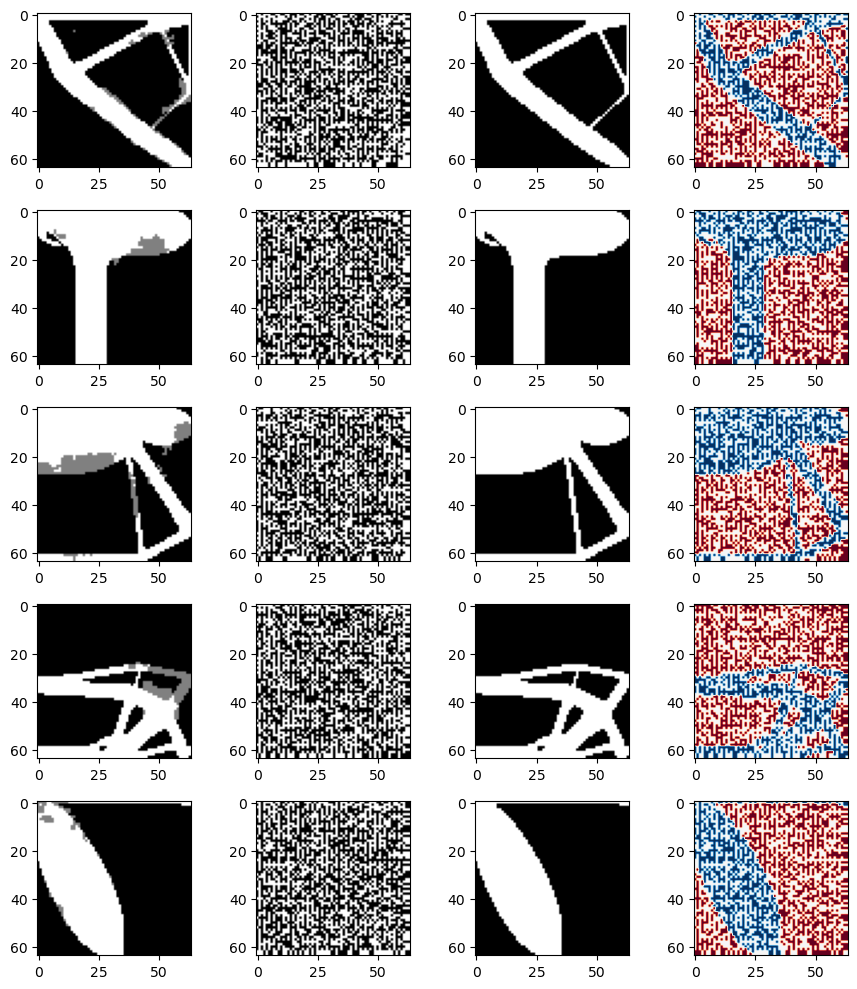

In [213]:
plot_reconstruction(topologies[originals], fixed_topologies2[originals], reconstructions_test4[originals])
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions_test[originals])

In [178]:
import numpy as np

num_ones = np.count_nonzero(fixed_topologies[0][0] == 1)
num_zeros = np.count_nonzero(fixed_topologies[0][0] == 0)

ratio = num_ones / num_zeros
print(ratio)

0.3333333333333333


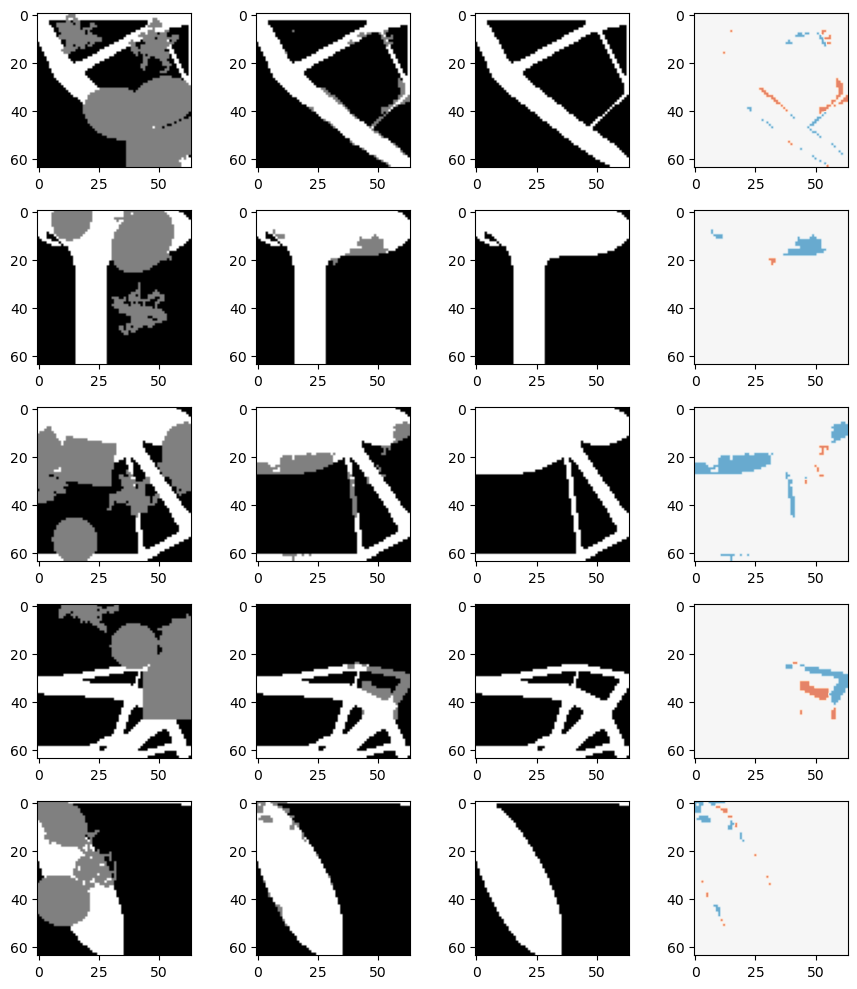

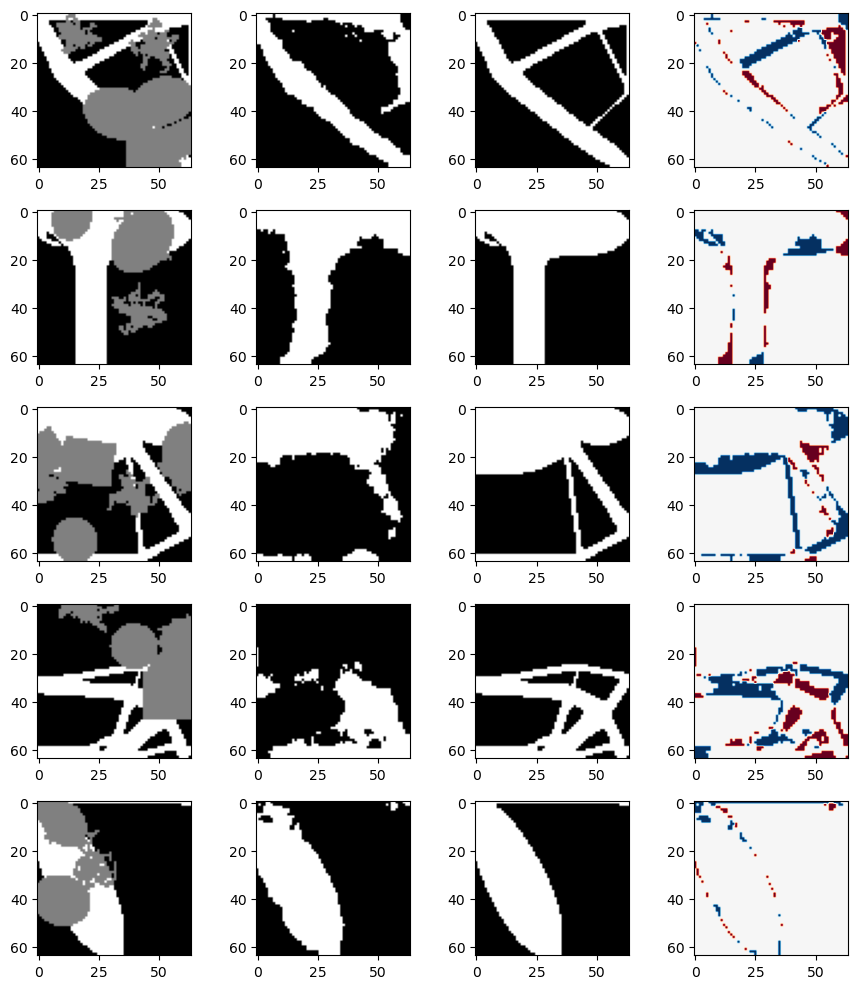

In [206]:
originals = np.random.choice(np.arange(len(masked_topologies_test)), size=5, replace=False) #Select 5 random indices
plot_reconstruction(topologies[originals], masked_topologies[originals], fixed_topologies2[originals]) #Compare
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions[originals]) #Compare

### Run VAE on intial reconstructions

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available

# reconstructions_VAE = reconstruct_from_vae(model, masked_topologies, device) #Reconstruct
data_in_tensor_2 = torch.from_numpy(reconstructions_VAE).float().to(device)
data_out_tensor_2 = torch.from_numpy(topologies).float().to(device)

#expand dims of tensor in channel 1
data_in_tensor_2 = data_in_tensor_2.unsqueeze(1)
data_out_tensor_2 = data_out_tensor_2.unsqueeze(1)

In [119]:
#Fixed Hyperparameters Trial 1 or 5 or 6
input_channels = 1
image_size = (64, 64)

latent_dim = 30
hidden_size = 128
num_layers = 2
kernel_size = 3
stride = 2
num_epochs = 20
batch_size = 64
lr=0.001

model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor_2, data_out_tensor_2)

Epoch 001:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1454.442


Epoch: 2 	Training Loss: 930.611


Epoch: 3 	Training Loss: 847.223


Epoch: 4 	Training Loss: 796.119


Epoch: 5 	Training Loss: 762.656


Epoch: 6 	Training Loss: 729.121


Epoch: 7 	Training Loss: 703.313


Epoch: 8 	Training Loss: 682.000


Epoch: 9 	Training Loss: 660.733


Epoch: 10 	Training Loss: 641.393


Epoch: 11 	Training Loss: 625.694


Epoch: 12 	Training Loss: 613.516


Epoch: 13 	Training Loss: 601.063


Epoch: 14 	Training Loss: 592.516


Epoch: 15 	Training Loss: 576.079


Epoch: 16 	Training Loss: 571.909


Epoch: 17 	Training Loss: 561.146


Epoch: 18 	Training Loss: 549.758


Epoch: 19 	Training Loss: 537.978


Epoch: 20 	Training Loss: 62.443


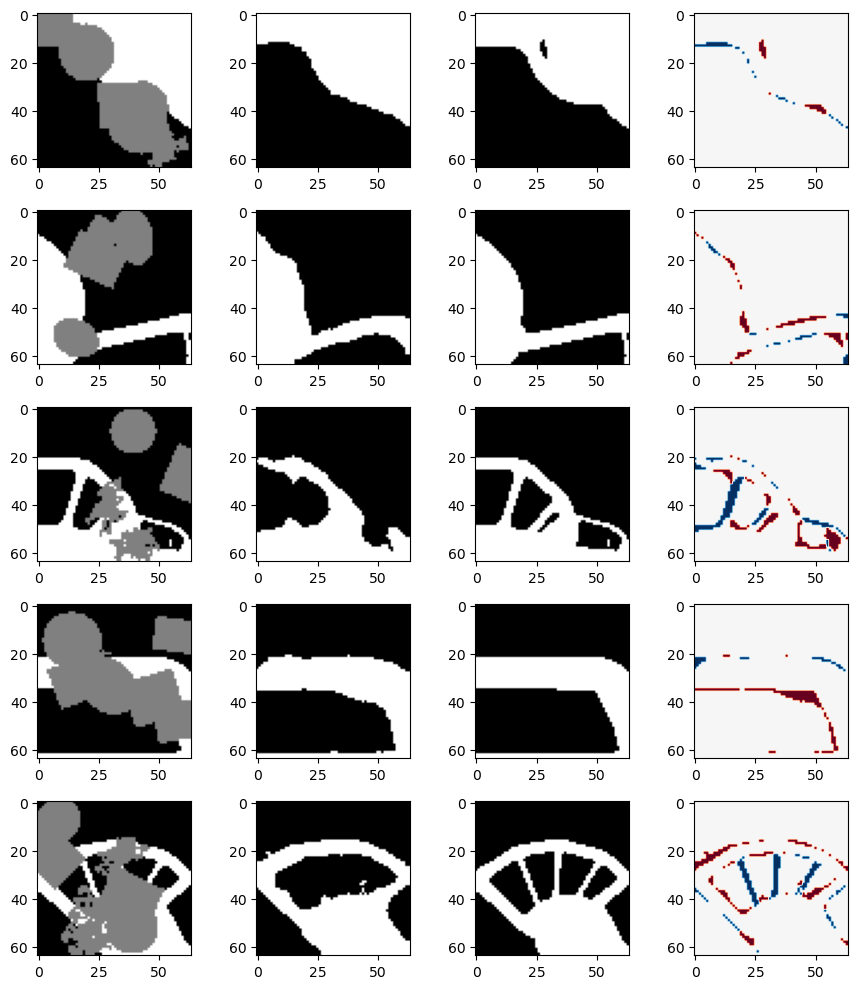

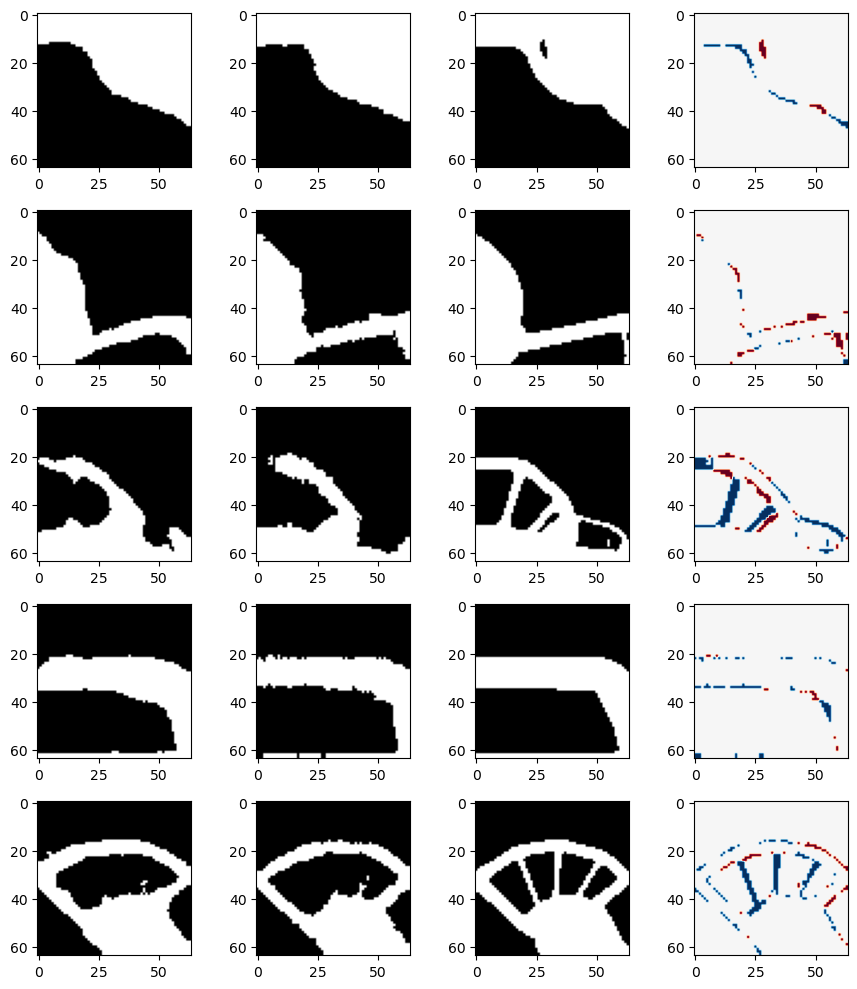

In [122]:
#trial 6
reconstructions_VAE_2_trial6 = reconstruct_from_vae(model, reconstructions_VAE, device) #Reconstruct 2nd loop

plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions_VAE[originals]) #Compare
plot_reconstruction(topologies[originals], reconstructions_VAE[originals], reconstructions_VAE_2_trial6[originals]) #Compare

In [125]:
reconstructions_VAE_2_trial6_test= reconstruct_from_vae(model, reconstructions_VAE_test, device) #Reconstruct 2nd loop
score=evaluate_score(masked_topologies_test, topologies_test, reconstructions_VAE_2_trial6_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.92380


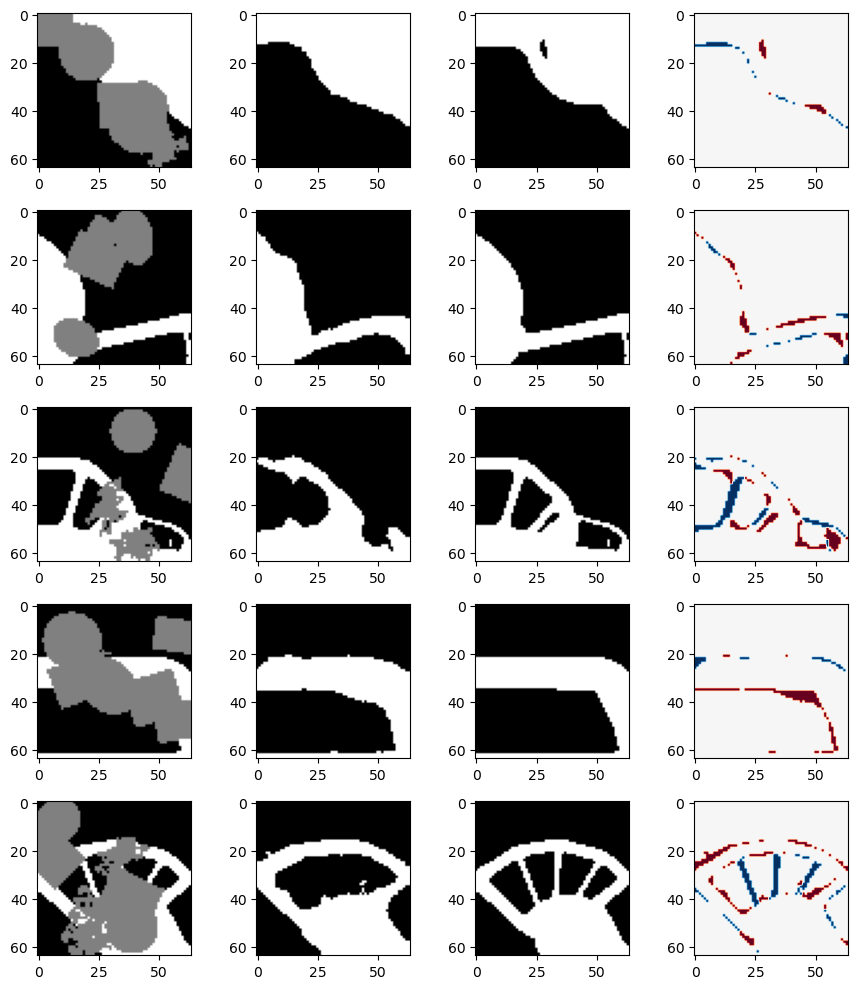

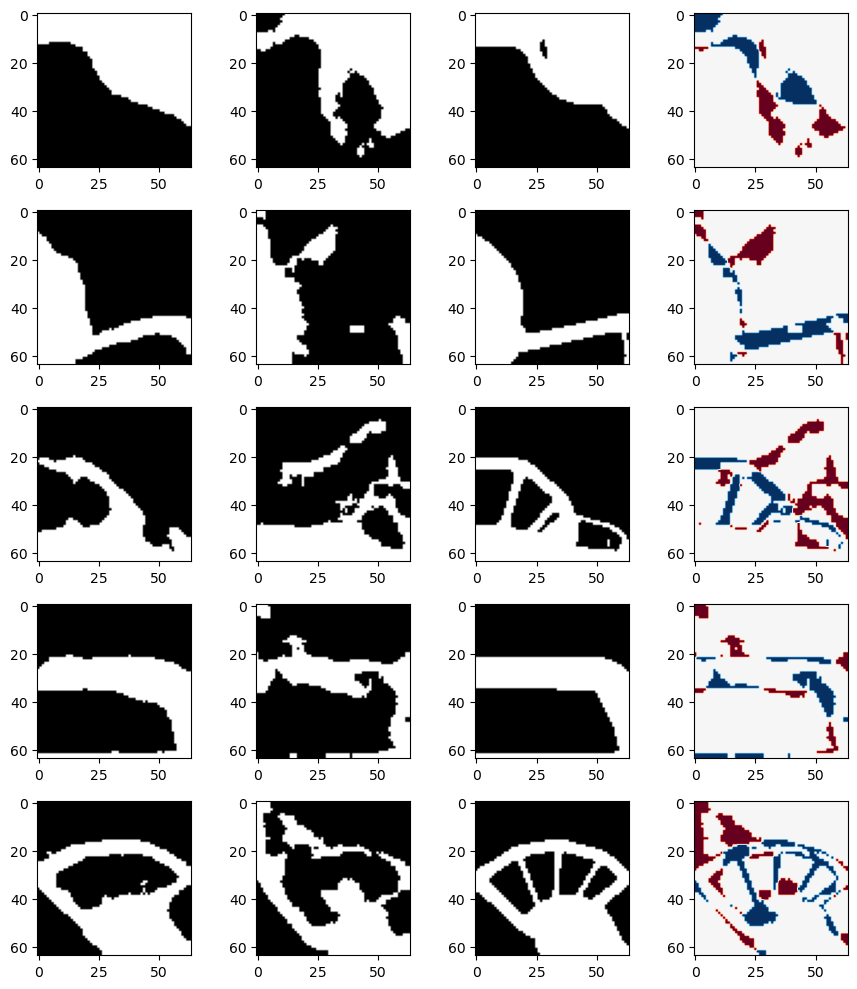

In [115]:
#trial 1 (best)
reconstructions_VAE_2_trial1 = reconstruct_from_vae(model, masked_topologies, device) #Reconstruct 2nd loop

plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions_VAE[originals]) #Compare
plot_reconstruction(topologies[originals], reconstructions_VAE[originals], reconstructions_VAE_2_trial1[originals]) #Compare

In [116]:
reconstructions_VAE_2_trial1_test= reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct 2nd loop
evaluate_score(masked_topologies_test, topologies_test, reconstructions_VAE_2_trial1_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.78373


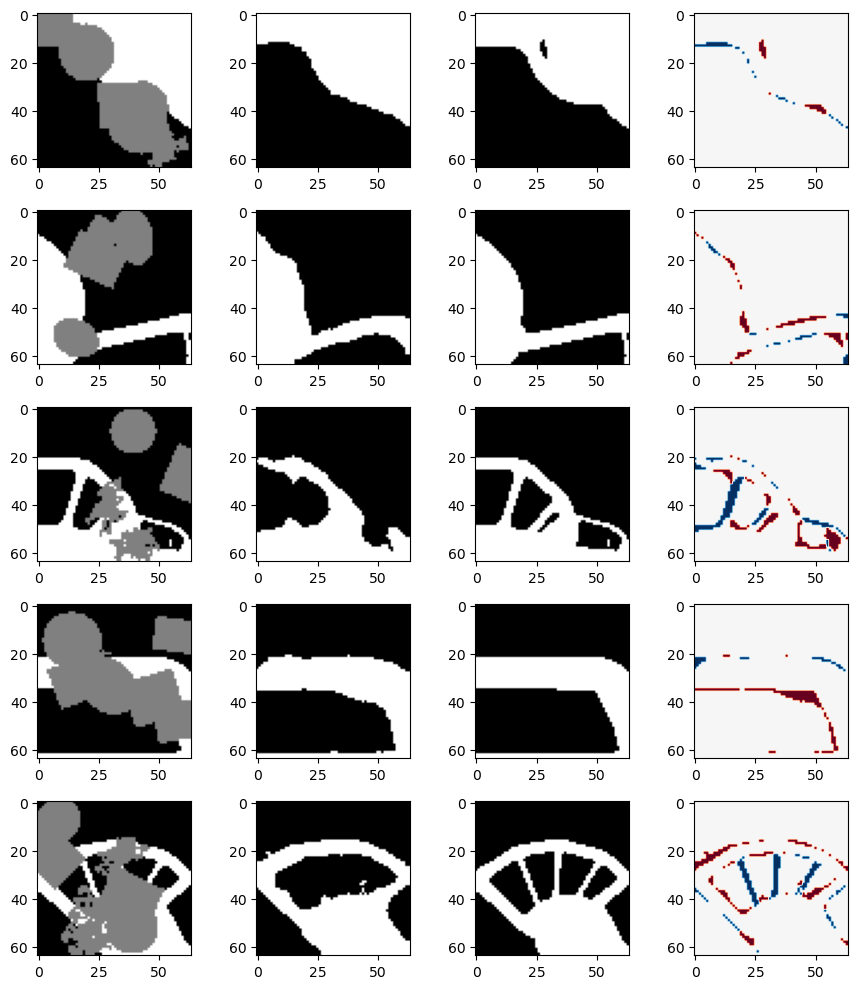

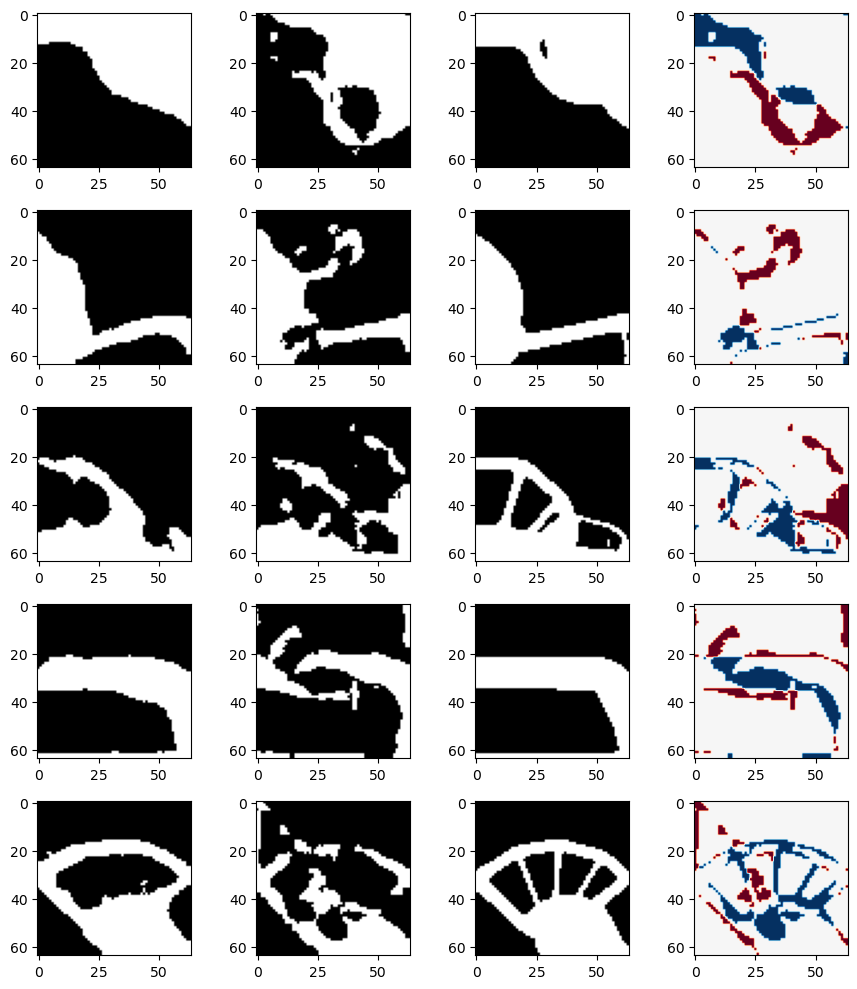

In [111]:
#trial 5 (bad overfit)
reconstructions_VAE_2_trial5 = reconstruct_from_vae(model, masked_topologies, device) #Reconstruct 2nd loop

plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions_VAE[originals]) #Compare
plot_reconstruction(topologies[originals], reconstructions_VAE[originals], reconstructions_VAE_2_trial5[originals]) #Compare

In [113]:
reconstructions_VAE_2_trial5_test= reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct 2nd loop
evaluate_score(masked_topologies_test, topologies_test, reconstructions_VAE_2_trial5_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.78373


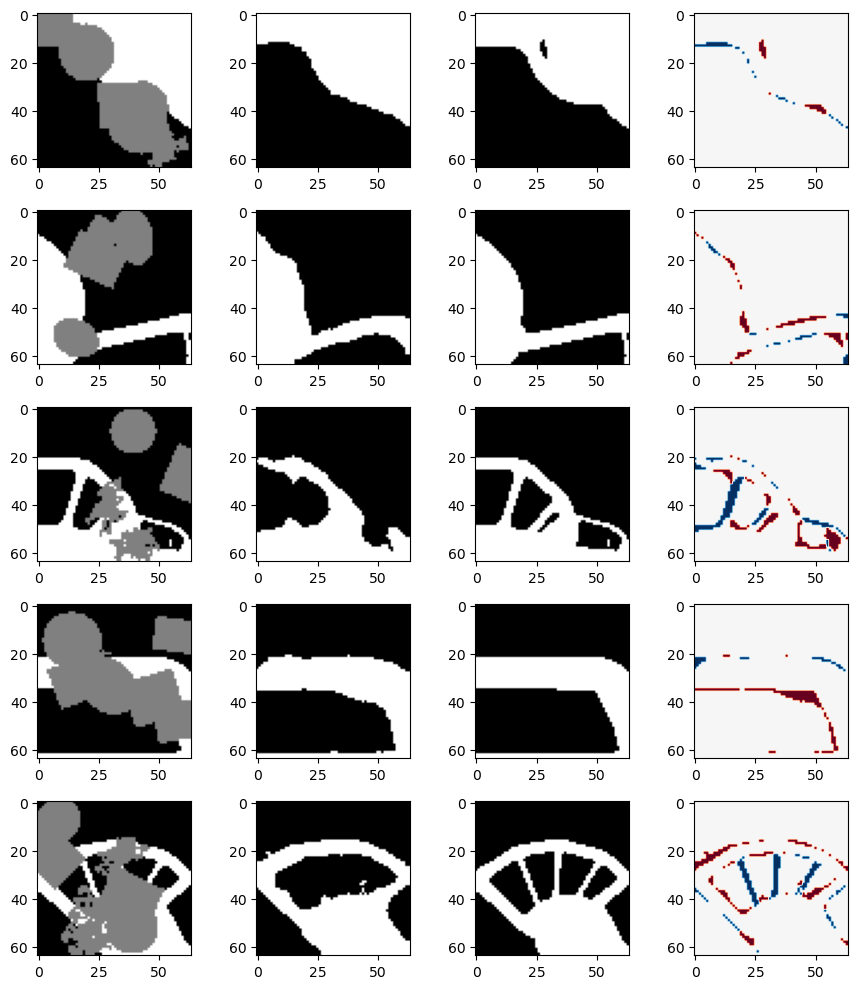

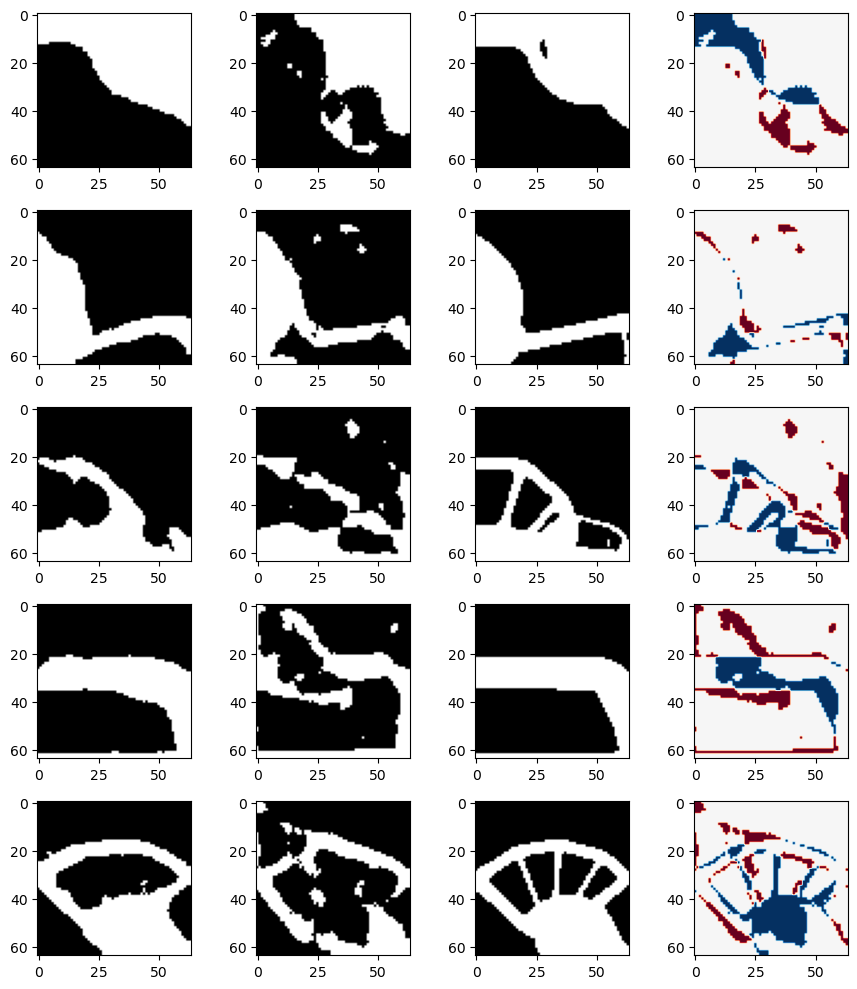

In [94]:
#original hyperparameters 
reconstructions_VAE_2 = reconstruct_from_vae(model, masked_topologies, device) #Reconstruct 2nd loop

originals = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False) #Select 5 random indices
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions_VAE[originals]) #Compare
plot_reconstruction(topologies[originals], reconstructions_VAE[originals], reconstructions_VAE_2[originals]) #Compare

In [96]:
#VAE 2 og hyper no validation
from copy import deepcopy
reconstructions_VAE_test=deepcopy(reconstructions_test)
reconstructions_VAE_2_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_VAE_test)
print(f"Final Accuracy: {score:.5f}")
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_VAE_2_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.93632
Final Accuracy: 0.78373


##### Tune Hyperparameters

In [101]:
#Train Hyperparameters
input_channels = 1
image_size = (64, 64)

latent_dims = [10, 20, 30]
hidden_sizes = [64, 128]
num_layers_list = [2, 3, 4, 5]
learning_rates = [1e-2, 1e-3, 1e-4]
kernel_size = 3
stride = 2
num_epochs = 20
batch_sizes = [64, 128, 256]

# To get accuracy scores
topologies_test = np.load("topologies_test.npy")
masked_topologies_test = np.load("masked_topologies_test.npy")


# To get submission set
masked_topologies_submission = np.load("masked_topologies_submission.npy")

# model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Random search
num_trials = 10  # Number of trials
best_accuracy = 0
best_hyperparams = {}

for trial in range(num_trials):
    #Random hyperparamaters
    latent_dim = np.random.choice(latent_dims)
    hidden_size = np.random.choice(hidden_sizes)
    num_layers = np.random.choice(num_layers_list)
    lr = np.random.choice(learning_rates)
    batch_size = np.random.choice(batch_sizes)
    print("Trial:", trial, "Latent Dim:", latent_dim, "Hidden Size:", 
          hidden_size, "Num Layers:", num_layers, "Learning Rate:", 
          lr, "Batch Size:", batch_size)
    # Initialize the model
    model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    # Main loop
    for epoch in range(1, num_epochs + 1):
      train(epoch, data_in_tensor, data_out_tensor)

    # Evaluate the model 
    reconstructions_test_0 = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
    accuracy = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test_0)
    print(trial, ":", accuracy)

    # Update best model if this model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparams = {'latent_dim': latent_dim, 'hidden_size': hidden_size, 'num_layers': num_layers, 'lr': lr}
        
        reconstructions_submission = reconstruct_from_vae(model, masked_topologies_submission, device) #Reconstruct
        reconstructions_submission = np.round(reconstructions_submission).astype(bool)
        np.save("CP3_final_submission%i.npy"%trial, reconstructions_submission)

print("Best Hyperparameters:", best_hyperparams)
print("Best Accuracy:", best_accuracy)

#Let's look at a model summary
# from torchsummary import summary
# print((input_channels, image_size[0], image_size[1]))
# summary(model, input_size=(input_channels, image_size[0], image_size[1]))

Trial: 0 Latent Dim: 10 Hidden Size: 64 Num Layers: 2 Learning Rate: 0.001 Batch Size: 256


Epoch 001:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2608.984


Epoch: 2 	Training Loss: 1753.419


Epoch: 3 	Training Loss: 1522.416


Epoch: 4 	Training Loss: 1412.359


Epoch: 5 	Training Loss: 1341.757


Epoch: 6 	Training Loss: 1287.648


Epoch: 7 	Training Loss: 1258.120


Epoch: 8 	Training Loss: 1234.712


Epoch: 9 	Training Loss: 1207.454


Epoch: 10 	Training Loss: 1177.722


Epoch: 11 	Training Loss: 1177.677


Epoch: 12 	Training Loss: 1148.110


Epoch: 13 	Training Loss: 1129.192


Epoch: 14 	Training Loss: 1119.904


Epoch: 15 	Training Loss: 1101.837


Epoch: 16 	Training Loss: 1081.724


Epoch: 17 	Training Loss: 1079.427


Epoch: 18 	Training Loss: 1079.668


Epoch: 19 	Training Loss: 1071.116


Epoch: 20 	Training Loss: 1062.910
0 : 0.881414156158617
Trial: 1 Latent Dim: 20 Hidden Size: 64 Num Layers: 5 Learning Rate: 0.001 Batch Size: 64


Epoch: 1 	Training Loss: 2092.989


Epoch: 2 	Training Loss: 1324.170


Epoch: 3 	Training Loss: 1118.177


Epoch: 4 	Training Loss: 1013.681


Epoch: 5 	Training Loss: 943.810


Epoch: 6 	Training Loss: 896.822


Epoch: 7 	Training Loss: 870.898


Epoch: 8 	Training Loss: 835.969


Epoch: 9 	Training Loss: 810.113


Epoch: 10 	Training Loss: 794.144


Epoch: 11 	Training Loss: 767.793


Epoch: 12 	Training Loss: 739.850


Epoch: 13 	Training Loss: 719.639


Epoch: 14 	Training Loss: 708.222


Epoch: 15 	Training Loss: 697.439


Epoch: 16 	Training Loss: 692.335


Epoch: 17 	Training Loss: 686.432


Epoch: 18 	Training Loss: 683.253


Epoch: 19 	Training Loss: 680.025


Epoch: 20 	Training Loss: 669.179
1 : 0.9228568517621322
Trial: 2 Latent Dim: 10 Hidden Size: 64 Num Layers: 2 Learning Rate: 0.001 Batch Size: 128


Epoch: 1 	Training Loss: 2166.847


Epoch: 2 	Training Loss: 1500.963


Epoch: 3 	Training Loss: 1345.038


Epoch: 4 	Training Loss: 1279.152


Epoch: 5 	Training Loss: 1236.566


Epoch: 6 	Training Loss: 1200.649


Epoch: 7 	Training Loss: 1170.426


Epoch: 8 	Training Loss: 1148.084


Epoch: 9 	Training Loss: 1120.654


Epoch: 10 	Training Loss: 1102.783


Epoch: 11 	Training Loss: 1084.715


Epoch: 12 	Training Loss: 1050.488


Epoch: 13 	Training Loss: 1021.353


Epoch: 14 	Training Loss: 1002.456


Epoch: 15 	Training Loss: 1005.112


Epoch: 16 	Training Loss: 1030.992


Epoch: 17 	Training Loss: 1030.737


Epoch: 18 	Training Loss: 1010.172


Epoch: 19 	Training Loss: 997.728


Epoch: 20 	Training Loss: 990.173
2 : 0.8784881430283434
Trial: 3 Latent Dim: 20 Hidden Size: 64 Num Layers: 3 Learning Rate: 0.01 Batch Size: 256


Epoch: 1 	Training Loss: 6511.628


Epoch: 2 	Training Loss: 1502.576


Epoch: 3 	Training Loss: 1305.059


Epoch: 4 	Training Loss: 1226.289


Epoch: 5 	Training Loss: 1164.958


Epoch: 6 	Training Loss: 1121.409


Epoch: 7 	Training Loss: 1084.338


Epoch: 8 	Training Loss: 1043.516


Epoch: 9 	Training Loss: 998.564


Epoch: 10 	Training Loss: 975.921


Epoch: 11 	Training Loss: 946.355


Epoch: 12 	Training Loss: 938.593


Epoch: 13 	Training Loss: 907.011


Epoch: 14 	Training Loss: 890.192


Epoch: 15 	Training Loss: 869.302


Epoch: 16 	Training Loss: 848.747


Epoch: 17 	Training Loss: 839.271


Epoch: 18 	Training Loss: 840.132


Epoch: 19 	Training Loss: 827.020


Epoch: 20 	Training Loss: 828.617
3 : 0.9102342397849128
Trial: 4 Latent Dim: 20 Hidden Size: 128 Num Layers: 4 Learning Rate: 0.0001 Batch Size: 128


Epoch: 1 	Training Loss: 2611.056


Epoch: 2 	Training Loss: 1520.057


Epoch: 3 	Training Loss: 1229.159


Epoch: 4 	Training Loss: 1121.484


Epoch: 5 	Training Loss: 1050.897


Epoch: 6 	Training Loss: 999.207


Epoch: 7 	Training Loss: 964.833


Epoch: 8 	Training Loss: 941.162


Epoch: 9 	Training Loss: 914.920


Epoch: 10 	Training Loss: 887.916


Epoch: 11 	Training Loss: 869.522


Epoch: 12 	Training Loss: 858.616


Epoch: 13 	Training Loss: 841.840


Epoch: 14 	Training Loss: 819.444


Epoch: 15 	Training Loss: 807.515


Epoch: 16 	Training Loss: 786.825


Epoch: 17 	Training Loss: 770.673


Epoch: 18 	Training Loss: 755.137


Epoch: 19 	Training Loss: 742.948


Epoch: 20 	Training Loss: 732.681
4 : 0.9167349571202722
Trial: 5 Latent Dim: 30 Hidden Size: 128 Num Layers: 4 Learning Rate: 0.001 Batch Size: 64


Epoch: 1 	Training Loss: 1737.631


Epoch: 2 	Training Loss: 1042.949


Epoch: 3 	Training Loss: 878.305


Epoch: 4 	Training Loss: 789.175


Epoch: 5 	Training Loss: 744.081


Epoch: 6 	Training Loss: 710.410


Epoch: 7 	Training Loss: 677.899


Epoch: 8 	Training Loss: 644.240


Epoch: 9 	Training Loss: 616.424


Epoch: 10 	Training Loss: 598.318


Epoch: 11 	Training Loss: 590.269


Epoch: 12 	Training Loss: 607.826


Epoch: 13 	Training Loss: 583.887


Epoch: 14 	Training Loss: 568.822


Epoch: 15 	Training Loss: 67.277


Epoch: 16 	Training Loss: 40.409


Epoch: 17 	Training Loss: 2.539


Epoch: 18 	Training Loss: 0.000


Epoch: 19 	Training Loss: 0.000


Epoch: 20 	Training Loss: 0.000
5 : 0.9382314301393163
Trial: 6 Latent Dim: 30 Hidden Size: 128 Num Layers: 2 Learning Rate: 0.001 Batch Size: 64


Epoch: 1 	Training Loss: 2996.145


Epoch: 2 	Training Loss: 1441.081


Epoch: 3 	Training Loss: 1367.717


Epoch: 4 	Training Loss: 1289.808


Epoch: 5 	Training Loss: 1243.356


Epoch: 6 	Training Loss: 1101.267


Epoch: 7 	Training Loss: 1015.638


Epoch: 8 	Training Loss: 944.025


Epoch: 9 	Training Loss: 893.853


Epoch: 10 	Training Loss: 829.256


Epoch: 11 	Training Loss: 779.122


Epoch: 12 	Training Loss: 747.936


Epoch: 13 	Training Loss: 716.918


Epoch: 14 	Training Loss: 703.679


Epoch: 15 	Training Loss: 683.351


Epoch: 16 	Training Loss: 656.493


Epoch: 17 	Training Loss: 644.912


Epoch: 18 	Training Loss: 637.264


Epoch: 19 	Training Loss: 622.487


Epoch: 20 	Training Loss: 608.614


KeyboardInterrupt: 

In [102]:
reconstructions_test_0 = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
accuracy = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test_0)
print(trial, ":", accuracy)

6 : 0.9186493828379398


##### Best Hyperparameters

In [ ]:
#Trial: 1 Latent Dim: 20 Hidden Size: 64 Num Layers: 5 Learning Rate: 0.001 Batch Size: 64
#1 : 0.9228568517621322
#Trial: 5 Latent Dim: 30 Hidden Size: 128 Num Layers: 4 Learning Rate: 0.001 Batch Size: 64
#5 : 0.9382314301393163 (overfit?)
#Trial: 6 Latent Dim: 30 Hidden Size: 128 Num Layers: 2 Learning Rate: 0.001 Batch Size: 64
#0.9186493828379398

### Testing

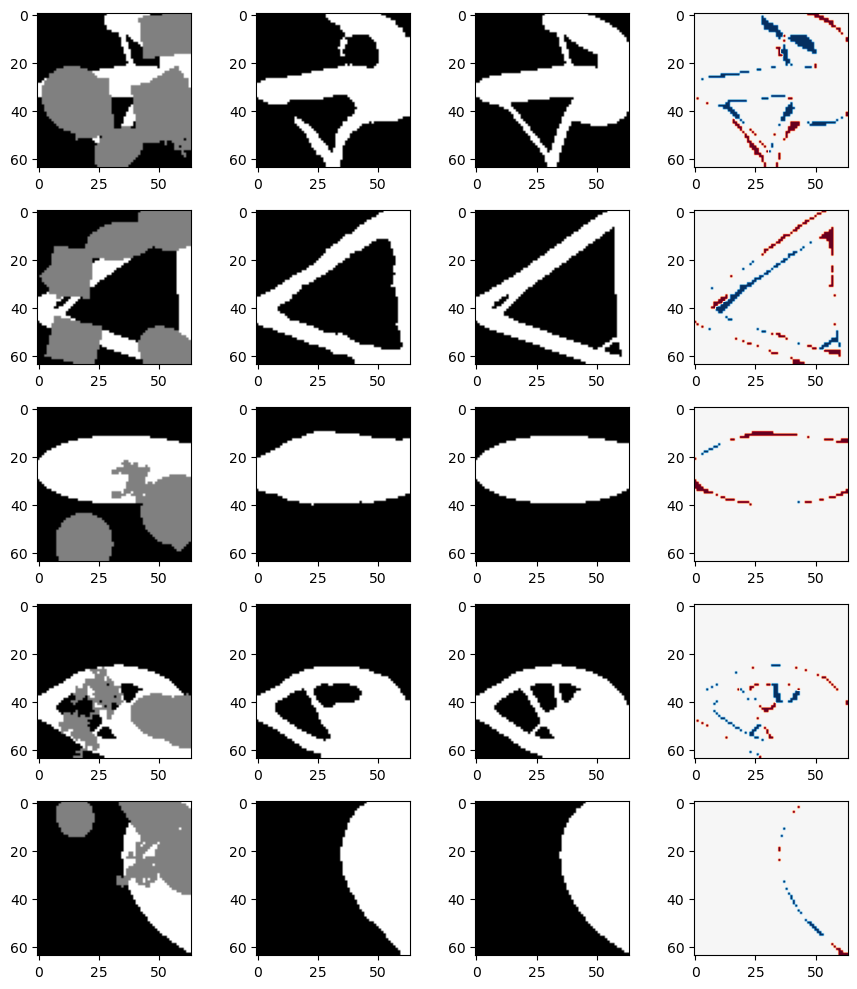

In [26]:
def reconstruct_from_vae(model, masked_topologies, device='cpu'):
    with torch.no_grad():
        data_in = torch.from_numpy(masked_topologies).float()
        data_in = data_in.unsqueeze(1).to(device)
        samples = model(data_in)[0][:,0,:,:].to('cpu').numpy()
        samples = np.round(samples)
    return samples

def plot_reconstruction(originals, masked, reconstructions):
    # Function to plot reconstructed city grids alongside originals
    n = len(originals)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(9, 2*n))
    for i in range(n): # Loop over the grids
        axes[i,0].imshow(masked[i], cmap = "gray") # Plot masked on the left
        axes[i,1].imshow(reconstructions[i], cmap = "gray") # Plot reconstruction on the left
        axes[i,2].imshow(originals[i], cmap = "gray") #Plot originals on the right
        axes[i,3].imshow(originals[i]-reconstructions[i], cmap = "RdBu", vmin=-1, vmax=1) #Plot error on the right
    fig.tight_layout()
    plt.show()
    
#latent 30 no val
originals = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False) #Select 5 random indices
reconstructions = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions) #Compare

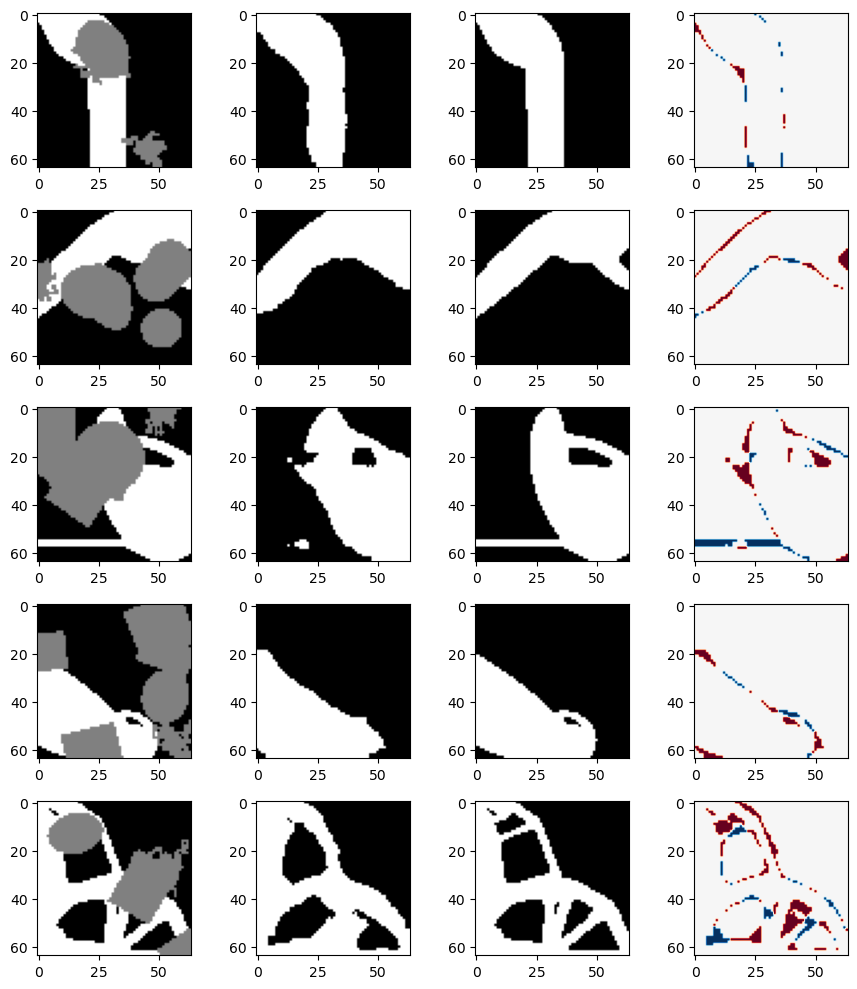

In [88]:
#latent 40 no val
originals = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False) #Select 5 random indices
reconstructions = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions) #Compare

##### Val Plot

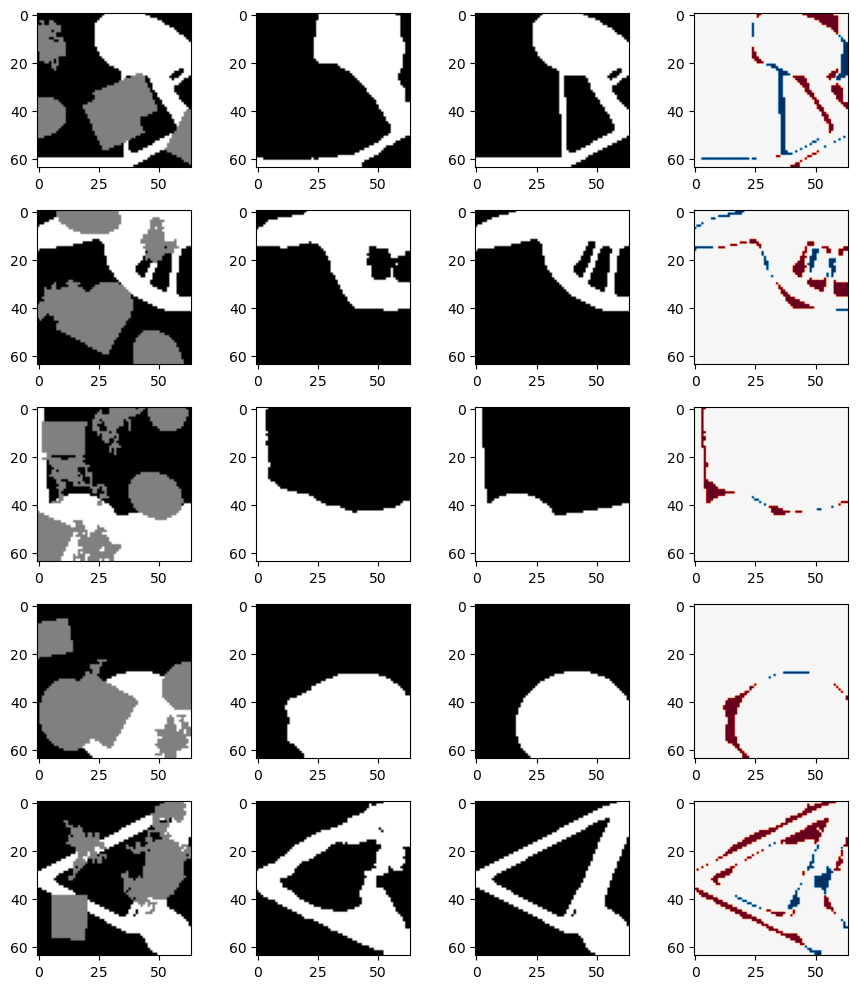

In [53]:
#latent 30 val yes
reconstructions = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions) #Compare

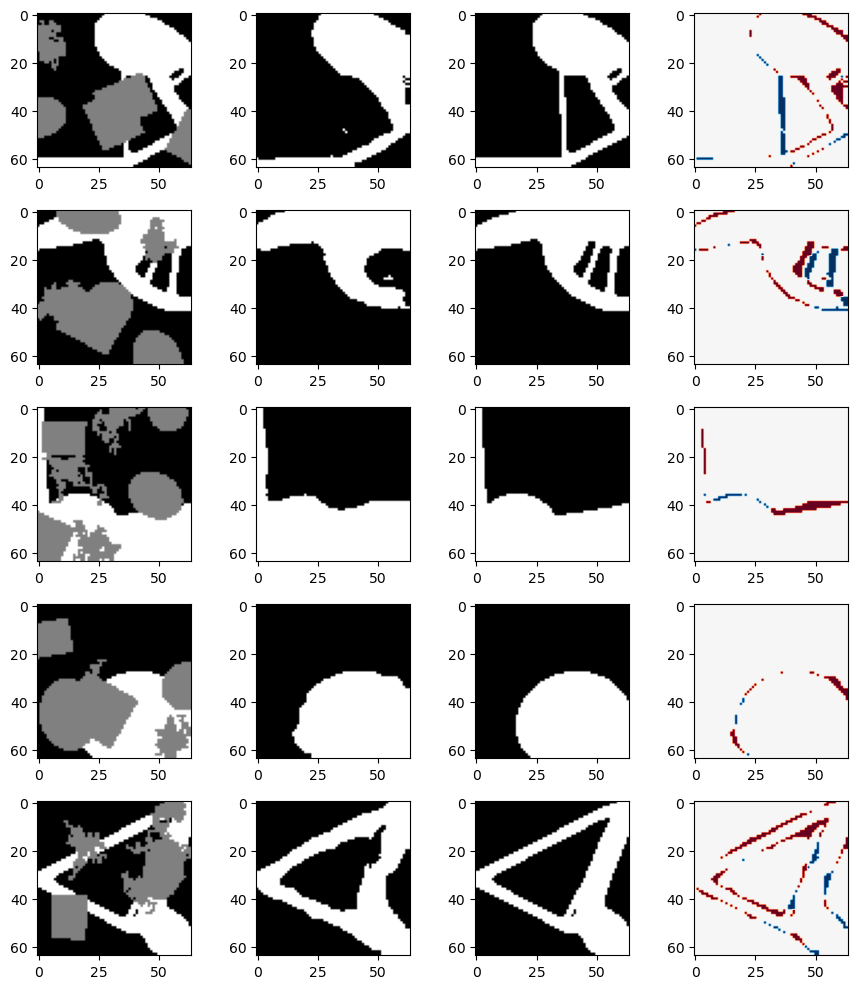

In [61]:
#latent 40 val yes
reconstructions = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions) #Compare

##### VAE2 Plot

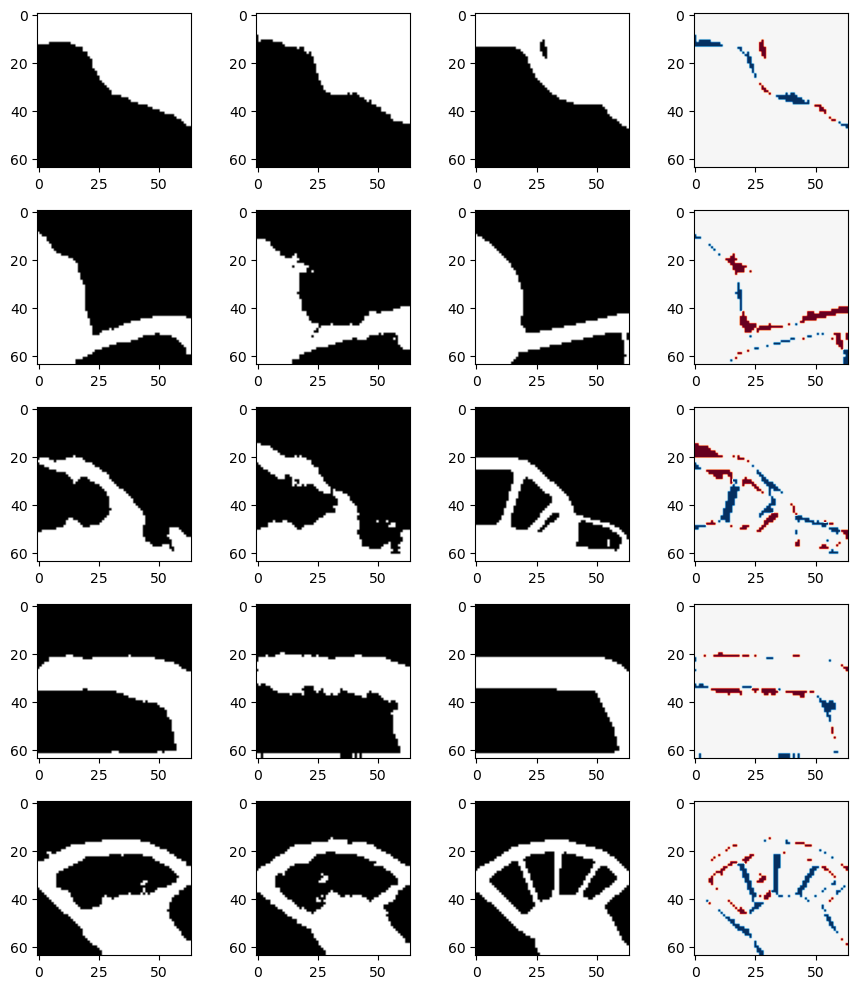

In [107]:
#Trial: 6 Latent Dim: 30 Hidden Size: 128 Num Layers: 2 Learning Rate: 0.001 Batch Size: 64
# originals = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False) #Select 5 random indices
reconstructions_2 = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], reconstructions_VAE[originals], reconstructions_2) #Compare

##### Testing

**Testing:**

Great! Now, it's time to test our model's performance. In this challenge problem we have provided a **test set** of masked topologies as well as their unmasked counterparts (as well as masked and unmasked constraints - if you choose to use them). The goal of this test set if for you to have an unbiased metric for the performance of you model. Test set scores will also be self-reported to the leaderboard. Please try to keep our leaderboard accurate - Do not bias your model by training on the test set or even tuning hyperparameters on the test set (this is what validation is for).

Though we know you are all honest, we want to ensure there is no accidental overfitting. As such, we will ask you to submit final predictions on a **submission set.** There is no systematic difference between the submission set and the test set (or the train set, for that matter). However, we will only provide the masked topologies and constraints on the submission set and not the ground truth. When you submit your report, please submit final predictions on the submission set, not the test set.

Ok, let's evaluate on the test set. We load up the masked topologies and the ground truth topologies of the test set. We pass the masked topologies into our VAE for predictions.

In [74]:
topologies_test = np.load("topologies_test.npy")
masked_topologies_test = np.load("masked_topologies_test.npy")
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct

#### **Scoring Function:**

Here is the evaluation function that we will be using: We simply calculate the fraction of pixels predicted accurately within the masked proportion of the topology. This is essentially the classic "accuracy" score in a binary classification problem - calculated over all pixels in the mask. We then average the accuracy values over all topologies.

In [80]:
def evaluate_score(masked_topologies, original_topologies, reconstructed_topologies):
    masks = masked_topologies==0.5 #Identify the masked regions
    correct = reconstructed_topologies==original_topologies #Identify all correctly predicted pixels
    correct_in_mask = np.logical_and(correct, masks) # Identify all correctly predicted pixels within masked regions
    accuracy_fractions = np.sum(correct_in_mask, axis=(1,2))/np.sum(masks, axis=(1,2)) #(correct & mask)/#(mask) for each topology individually
    average_accuracy_fraction = np.mean(accuracy_fractions) #Average of these ratios across test set
    return average_accuracy_fraction

##### No Val Accuracy

In [22]:
#latent 30 no val
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.93454


In [83]:
#latent 40 no val
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.93632


##### Val Set Accuracy

In [47]:
#latent 40 yes val
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.93433


In [52]:
#latent 50 yes val
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.91960


##### **Preparing a Submission**

Preparing a submission is simple: We first load the masked topologies. We can visualize some to verify that all is in order.

<Figure size 640x480 with 0 Axes>

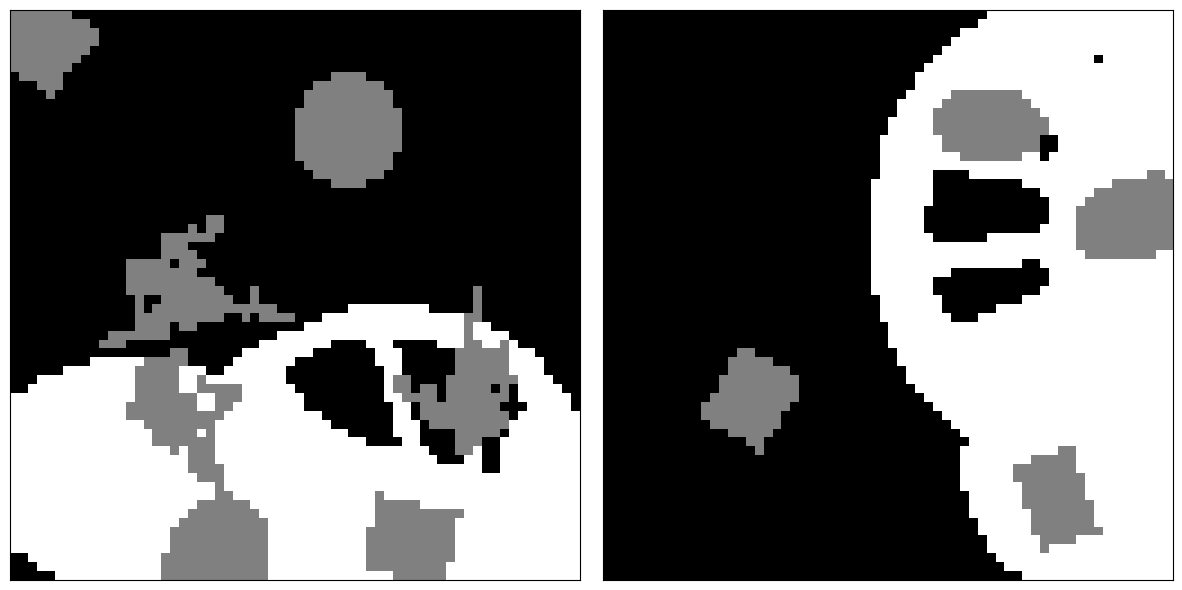

In [66]:
masked_topologies_submission = np.load("masked_topologies_submission.npy")
random_indices = np.random.choice(range(len(masked_topologies_submission)), 2)
plot_n_topologies(masked_topologies_submission[random_indices])

We pass them into our model to reconstruct (replace with your implementation here). We then binarize:

In [67]:
reconstructions_submission = reconstruct_from_vae(model, masked_topologies_submission, device) #Reconstruct
reconstructions_submission = np.round(reconstructions_submission).astype(bool)

We can visualize the reconstructions to double everything looks right:

<Figure size 640x480 with 0 Axes>

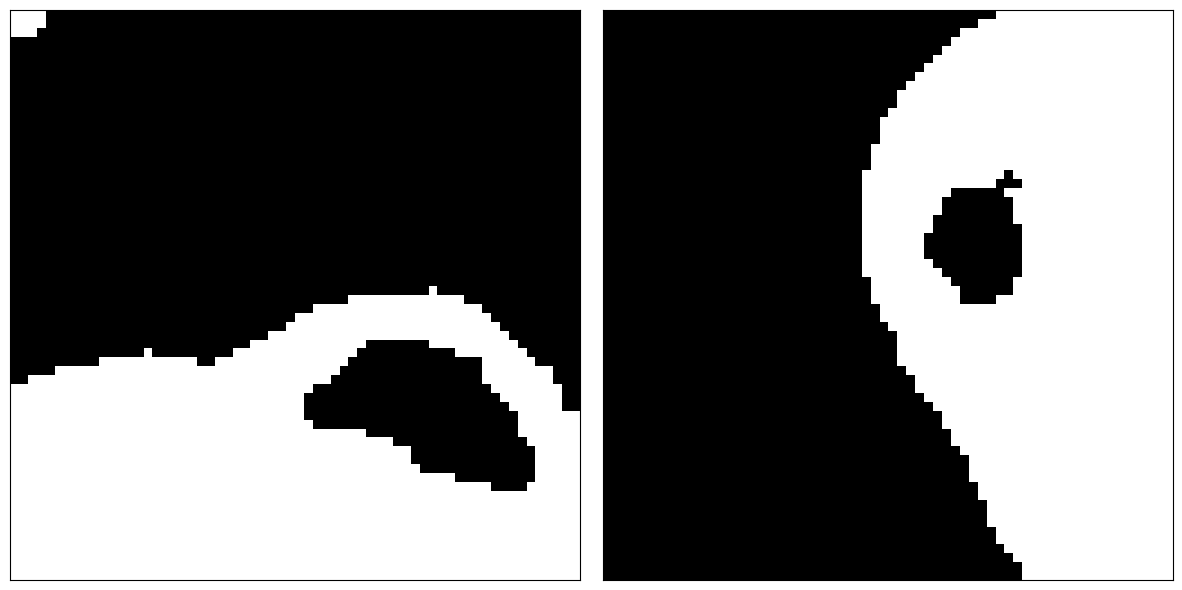

In [68]:
plot_n_topologies(reconstructions_submission[random_indices])

Assert everything is in the right shape:

In [69]:
assert reconstructions_submission.shape == (1200,64,64)
assert reconstructions_submission.dtype == bool

And we save our numpy array. Remember to download it if you run in colab.

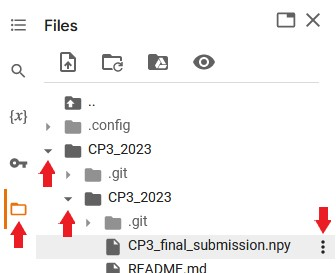

In [71]:
np.save("CP3_final_submission.npy", reconstructions_submission)

**THIS IS A FINAL REMINDER NOT TO SUBMIT THE TEST SET PREDICTIONS AS YOUR FINAL SUBMISSION**

**Some Notes:**

As with previous challenge problems, you can use whatever resources you like. These include, but are not limited to: Pretrained models, outside datasets, chatGPT, manual labeling (please don't tho), etc.

Some random links/references that are relevant:

https://openaccess.thecvf.com/content_cvpr_2018/papers/Yu_Generative_Image_Inpainting_CVPR_2018_paper.pdf

https://arxiv.org/pdf/1611.07004.pdf

https://arxiv.org/pdf/2208.09591.pdf

https://arxiv.org/pdf/2003.04685.pdf




### GAN

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils
# import torchvision.transforms as transforms


In [74]:
# Hyperparameters
batch_size = 64
learning_rate = 0.0002
epochs = 50
image_size = 64
input_channels = 1

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data_in, data_out):
        self.data_in = data_in
        self.data_out = data_out

    def __len__(self):
        return len(self.data_in)

    def __getitem__(self, idx):
        return self.data_in[idx], self.data_out[idx]

# Assuming data_in_tensor and data_out_tensor are your datasets
dataset = CustomDataset(data_in_tensor, data_out_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [107]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        output = output.view(output.size(0), -1)  # Flatten the output
        output = self.fc(output)
        return output

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), 100, 1, 1)  # Reshape input noise to a 4D tensor
        output = self.model(z)
        return output

# Instantiate models
discriminator = Discriminator()
generator = Generator()

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()


# Training loop
for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        # Prepare real and fake data
        real = images
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        discriminator.zero_grad()
        outputs = discriminator(real).view(batch_size, -1)  # Flatten the output
        d_loss_real = criterion(outputs, real_labels)
        z = torch.randn(batch_size, 100)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach()).view(batch_size, -1)  # Flatten the output
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        generator.zero_grad()
        z = torch.randn(batch_size, 100)
        fake_images = generator(z)
        outputs = discriminator(fake_images).view(batch_size, -1)  # Flatten the output
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

print("Training Complete")

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])


RuntimeError: shape '[64, -1]' is invalid for input of size 32

In [96]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def visualize_output(generator, device):
    # Generate batch of latent vectors
    noise = torch.randn(batch_size, 100, 1, 1, device=device)
    # Generate fake image batch with G
    fake = generator(noise).detach().cpu()
    img_list = vutils.make_grid(fake, padding=2, normalize=True)
    # Plot the fake images from the last epoch
    plt.imshow(np.transpose(img_list,(1,2,0)))
    plt.show()